In [1]:
#%%
import sys
sys.path.append('/home/gaoyuanw/Github/JaxSSO')
import JaxSSO.model as Model 
from JaxSSO import assemblemodel,solver
from JaxSSO.SSO_model import NodeParameter,ElementParameter,SSO_model
import numpy as np
import jax
import jax.numpy as jnp
from jax import jacfwd,grad,value_and_grad
from scipy.sparse.linalg import spsolve as spsolve_scipy
from scipy.sparse import csr_matrix
from jax.experimental import sparse
import os
#os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["TF_CPP_MIN_LOG_LEVEL"]="0"
jax.config.update("jax_enable_x64", True)
from jax.experimental import sparse
print(jax.__version__)
from platform import python_version
jax.config.update('jax_platform_name', 'cpu')
print(python_version())
import scipy
print(scipy.__version__)

import matplotlib.pyplot as plt
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from matplotlib.patches import Polygon

0.4.24
3.12.1
1.12.0


/tmp/ipykernel_2932832/734137169.py:27: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
n_col =40
n_row = n_col
x_span = 6
y_span = 6


# Nodal coordinates
xs = np.linspace(0,x_span,n_col+1)
xs = np.tile(xs,n_row+1)
ys = np.linspace(0,y_span,n_row+1)
ys = np.tile(ys,(n_col+1,1))
ys = ys.T.reshape(-1)
#zs =  0.2*(-(np.linspace(0,x_span,n_col+1)-x_span/2)**2+(x_span/2)**2)

zs =  0.1*(-(xs-x_span/2)**2+(x_span/2)**2
          -(ys-x_span/2)**2+(x_span/2)**2)

'''zs = np.tile(zs,n_row+1)
zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)'''
'''zs = np.where(xs==0,0,zs)
zs = np.where(xs==x_span,0,zs)
zs = np.where(ys==0,0,zs)
zs = np.where(ys==y_span,0,zs)
'''

# Connectivity
n_node = (n_col+1)*(n_row+1)
n_ele = n_col * n_row
cnct = np.zeros((n_ele,4),dtype=int) #Connectivity for MITC4
for i in range(n_ele):
    i_row = i//n_col
    i_col = (i-i_row*n_col)%n_col
    cnct[i,3] = i + i_row*1 + n_col + 1
    cnct[i,2] = cnct[i,3]+1 
    cnct[i,1] = cnct[i,2] - (n_col + 1)
    cnct[i,0] = cnct[i,1] - 1

#Properties, design nodes, load
t = 0.015
E = 2e10
nu = 0.3
design_nodes = []
non_design_nodes = []
loading_nodes = []
for i in range(n_node):
    design_nodes.append(i)
    if [xs[i],ys[i]]!= [x_span/2,0] and [xs[i],ys[i]] != [0,y_span/2] and [xs[i],ys[i]] != [x_span/2,y_span] and [xs[i],ys[i]] != [x_span,y_span/2]:
        #design_nodes.append(i)
        if [xs[i],ys[i]]== [0,0] or [xs[i],ys[i]]== [x_span/2,y_span/2] or [xs[i],ys[i]]== [x_span,0] or [xs[i],ys[i]]== [0,y_span] or [xs[i],ys[i]]== [x_span,y_span]:
            loading_nodes.append(i)
        
    else:
        non_design_nodes.append(i)
design_nodes = np.asarray(design_nodes)
non_design_nodes = np.asarray(non_design_nodes)
Q = 500

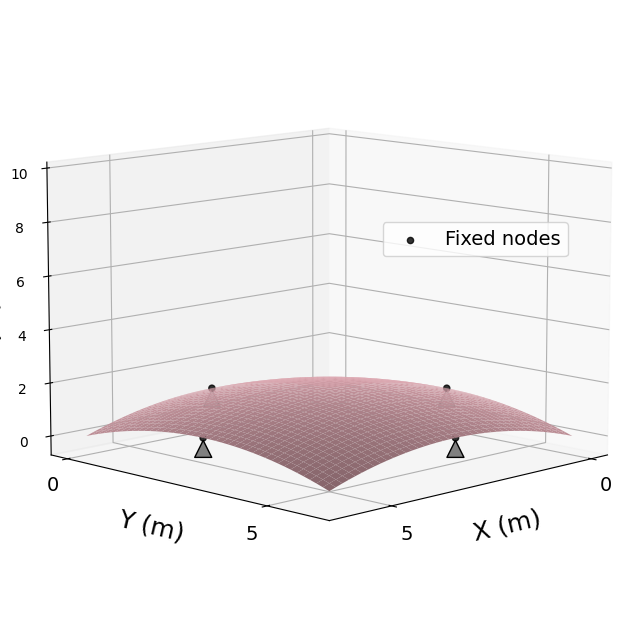

In [3]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

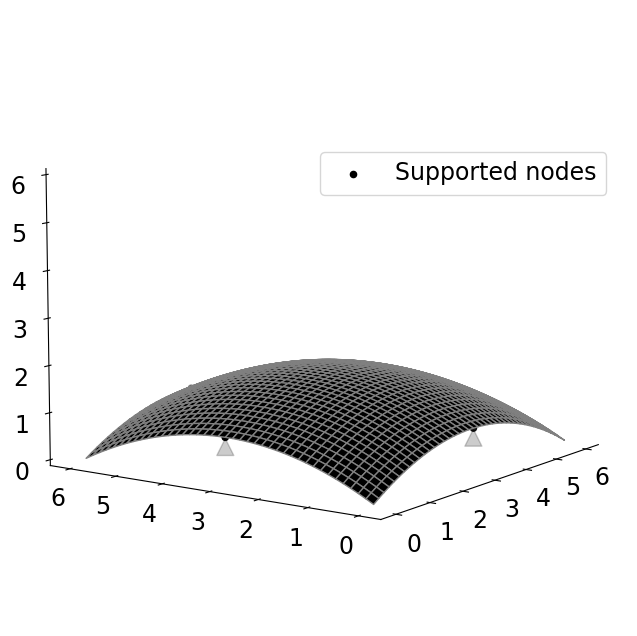

In [4]:
%matplotlib inline




fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,6)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=17)
ax.tick_params(axis='both', which='minor', labelsize=17)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')

all_corners = []


for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs[inode]],
                        [xs[jnode],ys[jnode],zs[jnode]],
                        [xs[mnode],ys[mnode],zs[mnode]],
                        [xs[nnode],ys[nnode],zs[nnode]],
                       ])

tdco = Poly3DCollection(all_corners)
tdco.set_alpha(1)
tdco.set_facecolor('black')
tdco.set_edgecolor('grey')
ax.add_collection3d(tdco)

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs[non_design_nodes]-0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10, -145)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

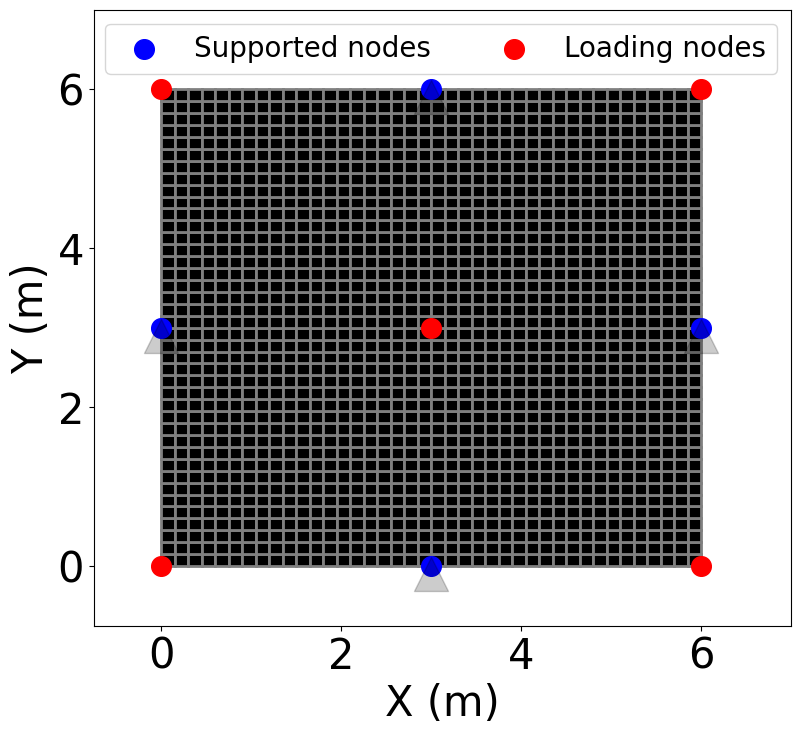

In [5]:
fig,ax = plt.subplots(figsize=(9,8))
ax.set_ylim(-0.75,7)
ax.set_xlim(-0.75,7)
#plt.title('{}-th iteration'.format(i))
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(1)
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('grey')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='blue',s=200,label='Supported nodes')
ax.scatter(xs[loading_nodes],ys[loading_nodes],color='red',s=200,label='Loading nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes]-0.1,s=600,marker='^',alpha=0.2,color='black')


#cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
#cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20,ncol=2)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [6]:
# Inputs of NN
# Embed some info
# 1. X,Y COORDINATES
# 2. Distance to the boundary: how close they are to the boundary
# 3. Centrality
from jax import vmap
def dis_boundary(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the minimum distance of each node to the boundary node
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    return jnp.min(vmap_norm(crd_xy,bound_xy),axis=1)

def v_centrality(x_nodes,y_nodes,non_design_nodes):
    '''
    Calculate the vertex centrality. Normalized so that minimum is "1".
    '''
    crd_xy = jnp.vstack((x_nodes.T,y_nodes.T)).T #shape (n_node,2)
    bound_xy = crd_xy[non_design_nodes,:] #xy of the boundary
    
    def xy_distance(xy_1,xy_2):
        return jnp.linalg.norm(xy_1-xy_2)
    xy_distance_vmap = vmap(xy_distance,in_axes=(None,0))
    vmap_norm = vmap(xy_distance_vmap,in_axes=(0,None))
    
    norm_min =jnp.min(jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1))
    norm_max = jnp.max(jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1))
    return (jnp.sum(vmap_norm(crd_xy,bound_xy),axis=1)-norm_min)/(norm_max-norm_min)

In [7]:
dis_b = dis_boundary(xs,ys,non_design_nodes)[design_nodes]
v_cen = v_centrality(xs,ys,non_design_nodes)

In [8]:
def Linear_filter(dist,R):
    '''
    A linear filter with radius R, will be normalized later to satisfy unit-intergral condition.
    '''
    return np.where(dist>R,0,(1/R)*(R-dist))

r = 1.5 #Radius

Mapping for nodal distance filter

In [9]:
#Matrix storing XY-projected distance  
dx_ij = xs[:,None]-xs[None,:]
dy_ij = ys[:,None]-ys[None,:]
D_ij = (dx_ij**2 + dy_ij**2)**0.5

#Create the filter mapping matrix
B_ij_ini = Linear_filter(D_ij,r)
B_ij_sum = np.sum(B_ij_ini,axis=1)
B_ij_sum = B_ij_sum.repeat(xs.shape[0]).reshape(xs.shape[0],xs.shape[0])
B_ij = B_ij_ini/B_ij_sum

In [10]:
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs_filtered)[design_nodes]

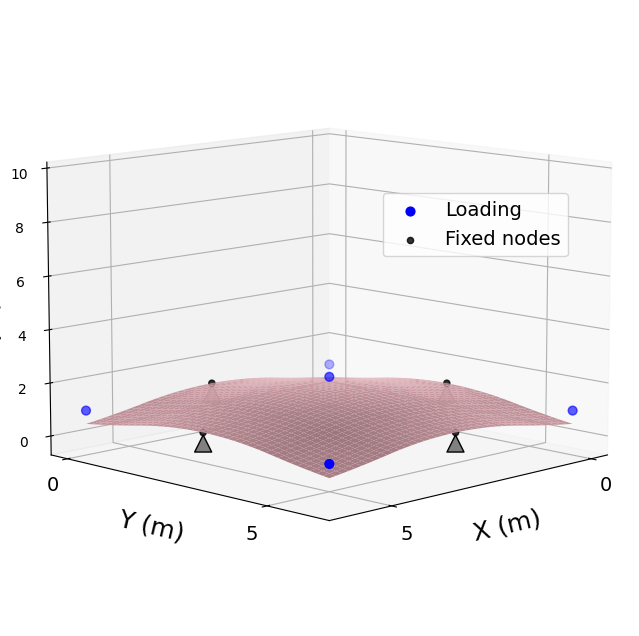

In [11]:
col = n_col+1
row = n_row+1 
fig = plt.figure(figsize=(10,8))
ax = plt.axes(projection='3d')
X = xs.reshape((row,col))
Y = ys.reshape((row,col))
Z = zs_filtered.reshape((row,col))
ax.set_xlabel('X (m)',fontsize=18)
ax.set_ylabel('Y (m)',fontsize=18)
ax.set_zlabel('Z (m)',fontsize=18)
plt.yticks([0,5,10,15,20],fontsize=14)
plt.xticks([0,5,10,15,20],fontsize=14)

ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 20)
ax.set_zlim(-0.5, 10)
ax.plot_surface(X, Y, Z, color='pink')#cmap=plt.cm.YlGnBu_r) 
ax.scatter(xs[loading_nodes],ys[loading_nodes],zs_filtered[loading_nodes]+0.5,color='blue',label='Loading',s=40)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes],color='black',alpha=0.8,label='Fixed nodes',s=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]-0.4, s=150, facecolors='grey', edgecolors='black',marker='^')
ax.view_init(10, 45)
plt.legend(loc=(0.6,0.6),fontsize=14)

Mapping for shell-center distance filter

In [12]:
xs_shell = np.average(xs[cnct],axis=1)
ys_shell = np.average(ys[cnct],axis=1)

In [13]:
#Matrix storing XY-projected distance  
dx_ij_shell = xs_shell[:,None]-xs_shell[None,:]
dy_ij_shell = ys_shell[:,None]-ys_shell[None,:]
D_ij_shell = (dx_ij_shell**2 + dy_ij_shell**2)**0.5

#Create the filter mapping matrix
B_ij_ini_shell = Linear_filter(D_ij_shell,0.25)
B_ij_sum_shell = np.sum(B_ij_ini_shell,axis=1)
B_ij_sum_shell = B_ij_sum_shell.repeat(xs_shell.shape[0]).reshape(xs_shell.shape[0],xs_shell.shape[0])
B_ij_shell = B_ij_ini_shell/B_ij_sum_shell

In [14]:
B_ij_shell.shape

(1600, 1600)

In [15]:
#W(A): total volume
def coeff_E(mu,p=7):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**p*E

def coeff_E2(mu):
    '''
    SIMP: modified stiffness with penalty
    mu is vector representing shell element's density ratio, between 0 and 1.
    E= mu^p * E_0 (p is the penalty factor and it is taken as 5)
    ''' 
    global E
    return mu**2*E


def og_p(p_norm):
    '''
    Return the un-normalized p
    '''
    p_max = 3
    p_min = 0
    return (p_max-p_min)*p_norm+p_min

def norm_p(p):
    p_max = 3
    p_min = 0
    return  (p-p_min)/(p_max-p_min)


def plt_plan(mu_opt_filtered,i=0):
    fig,ax = plt.subplots(figsize=(11,10))
    ax.set_ylim(-2,8)
    ax.set_xlim(-2,8)
    #plt.title('{}-th iteration'.format(i))
    plt.xlabel('X (m)',fontsize=30)
    plt.ylabel('Y (m)',fontsize=30)
    #ax = fig.add_subplot#(projection='3d')
    #ax.set_zlim(0,20)
    #ax.set_xlabel('X (m)',fontsize=15)
    #ax.set_ylabel('Y (m)',fontsize=15)
    #ax.set_zlabel('Z (m)',fontsize=15)
    all_corners= []
    import matplotlib as mpl
    cmap = mpl.colormaps['binary']
    for i in range(n_ele):
        inode = cnct[i,0]
        jnode = cnct[i,1]
        mnode = cnct[i,2]
        nnode = cnct[i,3]
        this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
        alpha = float(mu_opt_filtered[i])
        #cthis_poly.set_alpha(alpha)
        this_poly.set_facecolor(cmap(alpha))
        this_poly.set_edgecolor('black')
        this_poly.set_lw(2)
        ax.add_patch(this_poly)

    ax.tick_params(axis='both', which='major', labelsize=30)
    ax.tick_params(axis='both', which='minor', labelsize=30)
    #Plot a basic wireframe.
    #for i in range(n_ele_bar):
    ##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
    ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


    cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
    cb.ax.tick_params(labelsize=20)
    plt.legend(fontsize=20)# loc=(0.5,0.7))
    ax.grid(False)
    plt.show()

In [16]:
plt.plot(np.linspace(0,1,100),coeff_E(np.linspace(0,1,100)))

In [17]:
#%%
#Create model
model = Model.Model() #model for sensitivity analysis

#Adding nodes and boundary conditions
for i in range(n_node):
    model.add_node(i,xs[i],ys[i],zs_filtered[i])
    if i in non_design_nodes:
        model.add_support(i,[1,1,1,0,0,0]) #Pinned, only Ry allow
    if i in loading_nodes:
        model.add_nodal_load(i,nodal_load=[0.0,0.0,-Q,0.0,0.0,0.0])

#Adding elements
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    model.add_quad(i,inode, jnode, mnode, nnode, 
                t, E, nu)

model.model_ready()




In [18]:
model.solve()

In [19]:
# Start the SSO model
sso_model = SSO_model(model) # initial sso model


#Nodal parameter: for shape optimization
for node in design_nodes:
    nodeparameter = NodeParameter(node,2) # nodeparamter object
    sso_model.add_nodeparameter(nodeparameter)

#Element parameter: 
for eletag in range(n_ele):
    eleparameter = ElementParameter(eletag,ele_type = 1,prop_type = 1) # element object, quad's young's modulus
    sso_model.add_eleparameter(eleparameter)


#Initial the parameters
sso_model.initialize_parameters_values()
sso_model.set_objective(objective='strain energy',func=None,func_args=None)

# NN

1. Input of NN: 
* XY of nodes

2. Outoput:
* Z
* Density ?


In [20]:
import pymesh
from flax import linen as nn

In [21]:
class SimpleNN(nn.Module):
    num_hidden : int   # Number of hidden neurons
    num_outputs : int  # Number of output neurons
    num_layers: int #Number of hidden layers

    @nn.compact  # Tells Flax to look for defined submodules
    def __call__(self, x):
        # Perform the calculation of the model to determine the prediction
        for i in range(self.num_layers):
            x = nn.Dense(features=self.num_hidden)(x)
            #x = nn.BatchNorm(use_running_average=not train)(x)
            x = nn.relu(x)
        x = nn.Dense(features=self.num_outputs)(x)
        x = nn.sigmoid(x) #Between 0 and 1
        return x

In [29]:
n_input = 1 #(X,Y) of each node
n_hidden = 40 # neurons
n_out = 2 #Z of each node & density
n_layers =3 #number of hidden layers

rng = jax.random.PRNGKey(42)

inp = v_cen.reshape(v_cen.shape[0],1)
#rng, inp_rng, init_rng = jax.random.split(rng, 3)

In [30]:
NN = SimpleNN(n_hidden,n_out,n_layers)

In [31]:
rng, init_rng = jax.random.split(rng, 2)
rng, init_rng = jax.random.split(rng, 2)
# Initialize the model
params = NN.init(init_rng, inp)

In [32]:
import optax
optimizer = optax.adam(learning_rate=0.02)

In [33]:
from flax.training import train_state

model_state = train_state.TrainState.create(apply_fn=NN.apply,
                                            params=params,
                                            tx=optimizer)

In [34]:
def calculate_loss(state, params, inp,alpha=0.1, p_E=2):


    ##Apply_fn: ML input to output
    outs = state.apply_fn(params, inp) #shape (n_node,2)
    node_params = outs[:,0]
    node_rho_params = outs[:,1]
    
    #1. NN outputs to update shape (nodal-Z coordinate)
    p = jnp.array(zs).copy()
    p = p.at[design_nodes].set(og_p(node_params)) #Unnormalized Control pt
    z = (B_ij@p)[design_nodes] #filtered actual geometry pt
    
    #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.
    
    #2. NN outputs to update topology (density, NN output is per-node density, average for each shell)
    ele_params = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell
    filtered_mu = B_ij_shell@ele_params
    E_step = coeff_E(filtered_mu,p_E) #Penalized Young's modulus
    #sso_model.update_eleparameter(E_step) # Update the model
    
    #3. Loss function: penalized compliance
    parameter_values = jnp.hstack([z,E_step])
    compliance = sso_model.helper_params_to_objective(parameter_values,which_solver='sparse',enforce_scipy_sparse=True)
    # loss = compliance (normalized) + alpha *(volume/exp_volume -1)^2
    loss1 = compliance/40
    loss2 = alpha*(jnp.sum(filtered_mu)/(0.5*sso_model.eleparameters_values.shape[0])-1)**2
    loss =  loss1 + loss2
    return loss#loss1,loss2,z,filtered_mu

In [35]:
calculate_loss(model_state,params,inp)

Array(20.91385976, dtype=float64)

In [36]:
grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
loss, grads = grad_fn(model_state, model_state.params, inp)

In [37]:
@jax.jit  # Jit the function for efficiency
def train_step(state, inp,alpha=0.1, p=2):
    # Gradient function
    grad_fn = jax.value_and_grad(calculate_loss,  # Function to calculate the loss
                                 argnums=1,  # Parameters are second argument of the function
                                 has_aux=False  # Function has additional outputs, here accuracy
                                )
    # Determine gradients for current model, parameters and batch
    loss, grads = grad_fn(state, state.params, inp,alpha, p)
    # Perform parameter update with gradients and optimizer
    state = state.apply_gradients(grads=grads)
    # Return state and any other value we might want
    return state, loss

In [29]:
%timeit train_step(model_state, inp)

2.67 s ± 11.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
metrics_history = {'train_loss': []}
from tqdm import tqdm
loss_list =[]
def train_model(state, num_epochs=200):
    alpha = 0.1
    p = 2
    # Training loop
    for epoch in tqdm(range(num_epochs)):
        
        if alpha < 100:
            alpha = 0.1 +len(loss_list) * 0.05
        if p<8:
            p = 2 + 0.06*len(loss_list)
        print('Iter{}, alpha={}, p={}'.format(len(loss_list),alpha,p))
        state, loss = train_step(state, inp,alpha,p)
        metrics_history['train_loss'].append(loss)
        print('Train epoch {}'.format(len(metrics_history['train_loss'])+1)+'  ,loss:{}'.format(loss))
        # We could use the loss and accuracy for logging here, e.g. in TensorBoard
        # For simplicity, we skip this part here
        loss_list.append(loss)
        if len(loss_list)%5==0:
            i = len(loss_list)
            
            outs = state.apply_fn(state.params, inp) #shape (n_node,2)
            node_params = outs[:,0]
            node_rho_params = outs[:,1]



            #sso_model.update_nodeparameter(z) # Update the model, this step causes "leak".... try directly call sso's function.

            #2. NN outputs to update topology (density, NN output is per-node density, average for each shell)
            ele_params = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell
            filtered_mu = B_ij_shell@ele_params
            E_step = coeff_E(filtered_mu) #Penalized Young's modulus
            print(jnp.sum(ele_params))
            
            plt_plan(filtered_mu,i)
    return state

  0%|          | 0/205 [00:00<?, ?it/s]

Iter0, alpha=0.1, p=2.0


  0%|          | 1/205 [00:37<2:06:12, 37.12s/it]

Train epoch 2  ,loss:20.9138597582571
Iter1, alpha=0.15000000000000002, p=2.06


  1%|          | 2/205 [00:39<57:13, 16.91s/it]  

Train epoch 3  ,loss:15.580210618848405
Iter2, alpha=0.2, p=2.12


  1%|▏         | 3/205 [00:42<35:02, 10.41s/it]

Train epoch 4  ,loss:10.70953156465438
Iter3, alpha=0.25, p=2.18


  2%|▏         | 4/205 [00:45<24:38,  7.36s/it]

Train epoch 5  ,loss:7.555153325903167
Iter4, alpha=0.30000000000000004, p=2.24
Train epoch 6  ,loss:6.043804742926983
1258.9984560135988


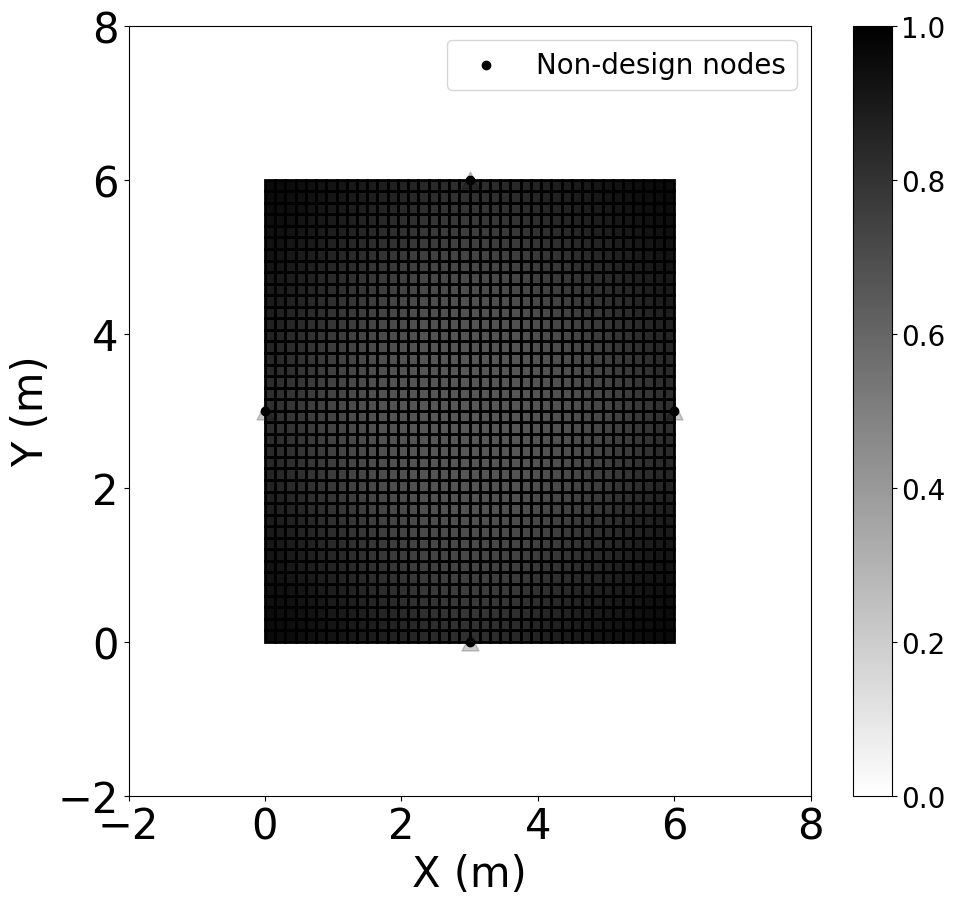

  2%|▏         | 5/205 [00:49<20:53,  6.27s/it]

Iter5, alpha=0.35, p=2.3


  3%|▎         | 6/205 [00:52<16:48,  5.07s/it]

Train epoch 7  ,loss:4.599677120609858
Iter6, alpha=0.4, p=2.36


  3%|▎         | 7/205 [00:55<14:12,  4.31s/it]

Train epoch 8  ,loss:3.4581119075003506
Iter7, alpha=0.45000000000000007, p=2.42


  4%|▍         | 8/205 [00:57<12:30,  3.81s/it]

Train epoch 9  ,loss:2.679476590408878
Iter8, alpha=0.5, p=2.48


  4%|▍         | 9/205 [01:00<11:19,  3.47s/it]

Train epoch 10  ,loss:2.1940847903655616
Iter9, alpha=0.55, p=2.54
Train epoch 11  ,loss:1.8804331750330492
1508.8866497528904


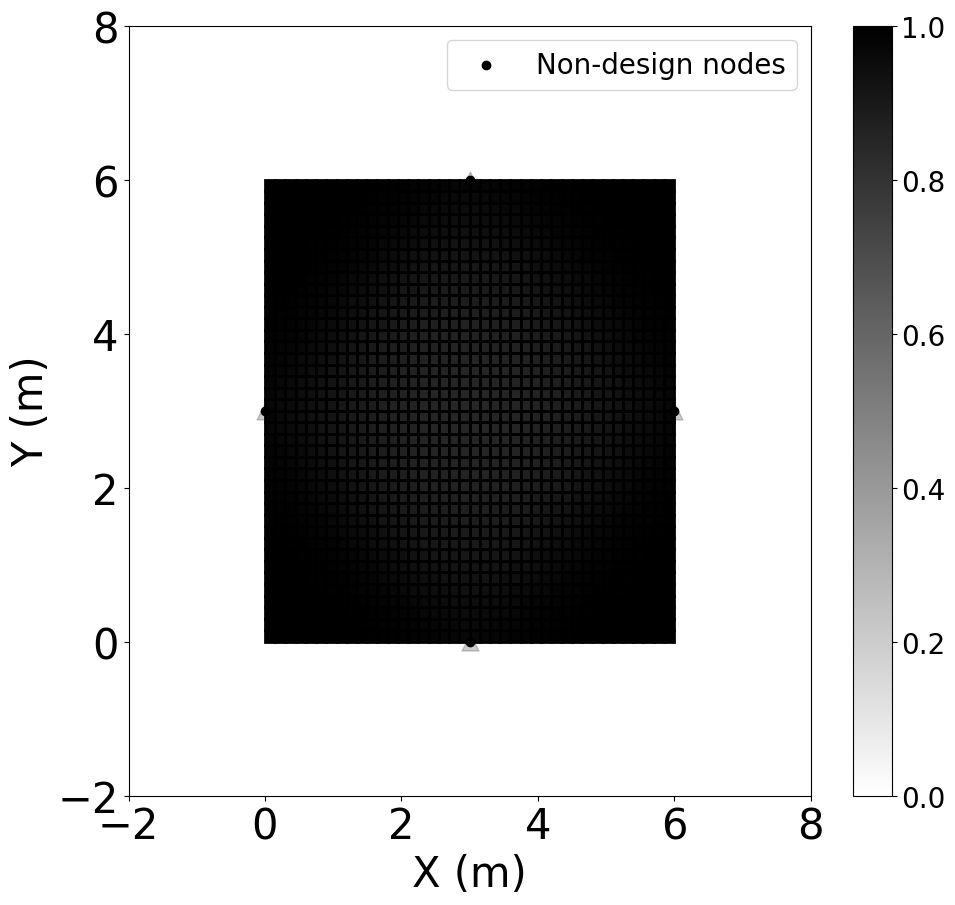

  5%|▍         | 10/205 [01:04<12:06,  3.72s/it]

Iter10, alpha=0.6, p=2.6


  5%|▌         | 11/205 [01:07<11:02,  3.42s/it]

Train epoch 12  ,loss:1.6118268120019892
Iter11, alpha=0.65, p=2.66


  6%|▌         | 12/205 [01:10<10:19,  3.21s/it]

Train epoch 13  ,loss:1.4315360530326133
Iter12, alpha=0.7000000000000001, p=2.7199999999999998


  6%|▋         | 13/205 [01:13<09:48,  3.07s/it]

Train epoch 14  ,loss:1.3364370010872644
Iter13, alpha=0.75, p=2.7800000000000002


  7%|▋         | 14/205 [01:15<09:27,  2.97s/it]

Train epoch 15  ,loss:1.3055550092622306
Iter14, alpha=0.8, p=2.84
Train epoch 16  ,loss:1.3105534109391368
1565.7626503283732


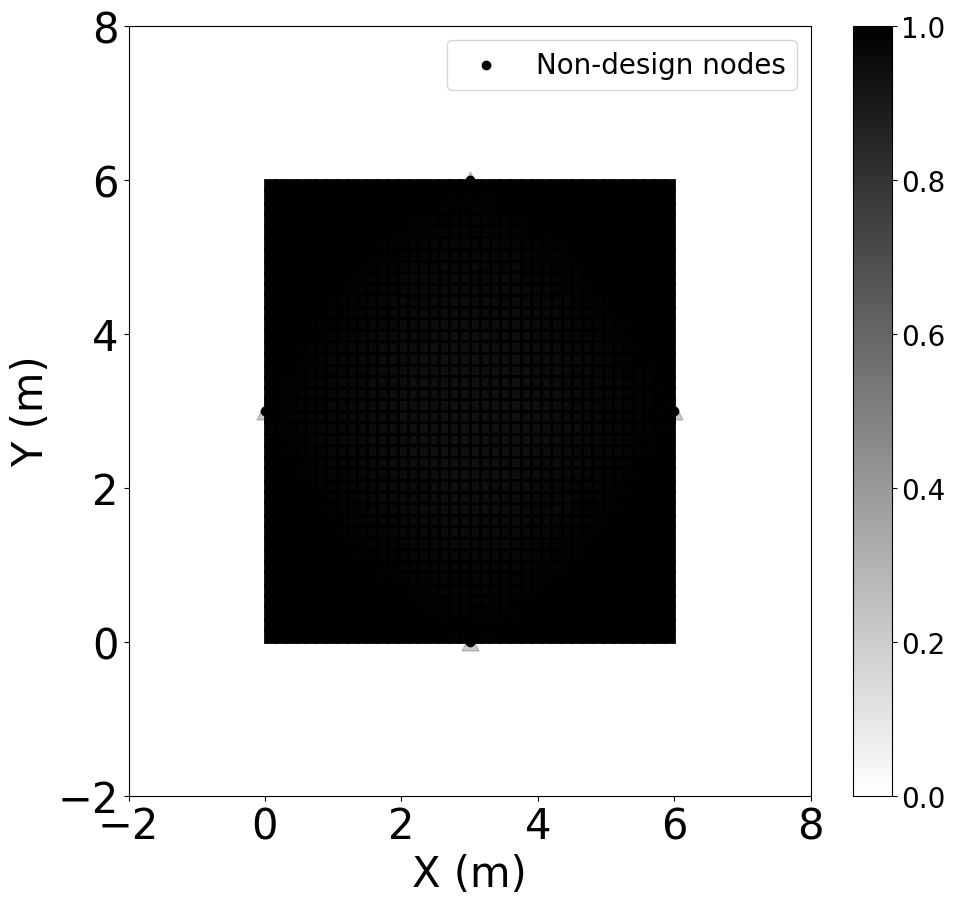

  7%|▋         | 15/205 [01:19<10:25,  3.29s/it]

Iter15, alpha=0.85, p=2.9


  8%|▊         | 16/205 [01:22<09:53,  3.14s/it]

Train epoch 17  ,loss:1.3221738795218283
Iter16, alpha=0.9, p=2.96


  8%|▊         | 17/205 [01:25<09:29,  3.03s/it]

Train epoch 18  ,loss:1.324255192036162
Iter17, alpha=0.9500000000000001, p=3.02


  9%|▉         | 18/205 [01:28<09:11,  2.95s/it]

Train epoch 19  ,loss:1.3185313668744658
Iter18, alpha=1.0, p=3.08


  9%|▉         | 19/205 [01:30<08:57,  2.89s/it]

Train epoch 20  ,loss:1.3161981505616298
Iter19, alpha=1.05, p=3.1399999999999997
Train epoch 21  ,loss:1.3249779553382108
1579.9966117319375


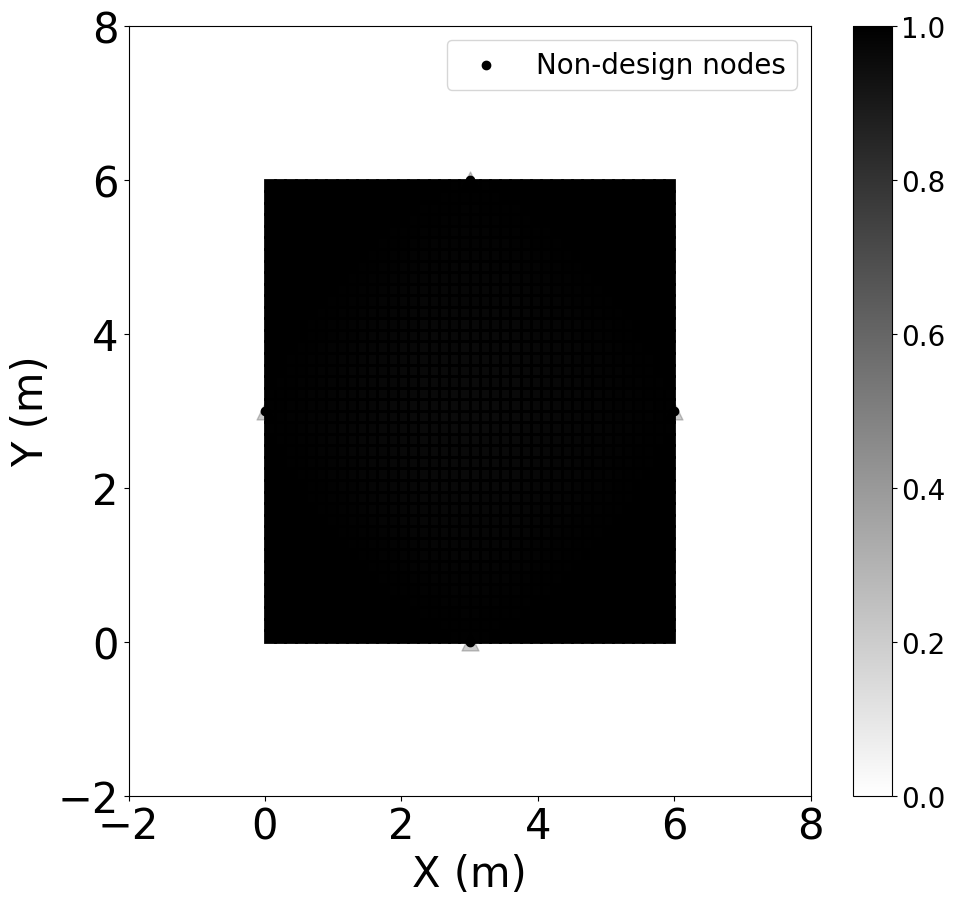

 10%|▉         | 20/205 [01:35<10:15,  3.32s/it]

Iter20, alpha=1.1, p=3.2


 10%|█         | 21/205 [01:37<09:39,  3.15s/it]

Train epoch 22  ,loss:1.345247835167361
Iter21, alpha=1.1500000000000001, p=3.26


 11%|█         | 22/205 [01:40<09:14,  3.03s/it]

Train epoch 23  ,loss:1.3739466737641801
Iter22, alpha=1.2000000000000002, p=3.32


 11%|█         | 23/205 [01:43<08:55,  2.94s/it]

Train epoch 24  ,loss:1.4073031810357712
Iter23, alpha=1.2500000000000002, p=3.38


 12%|█▏        | 24/205 [01:46<08:40,  2.88s/it]

Train epoch 25  ,loss:1.4425093078380518
Iter24, alpha=1.3000000000000003, p=3.44
Train epoch 26  ,loss:1.4777992356096699
1580.070415852185


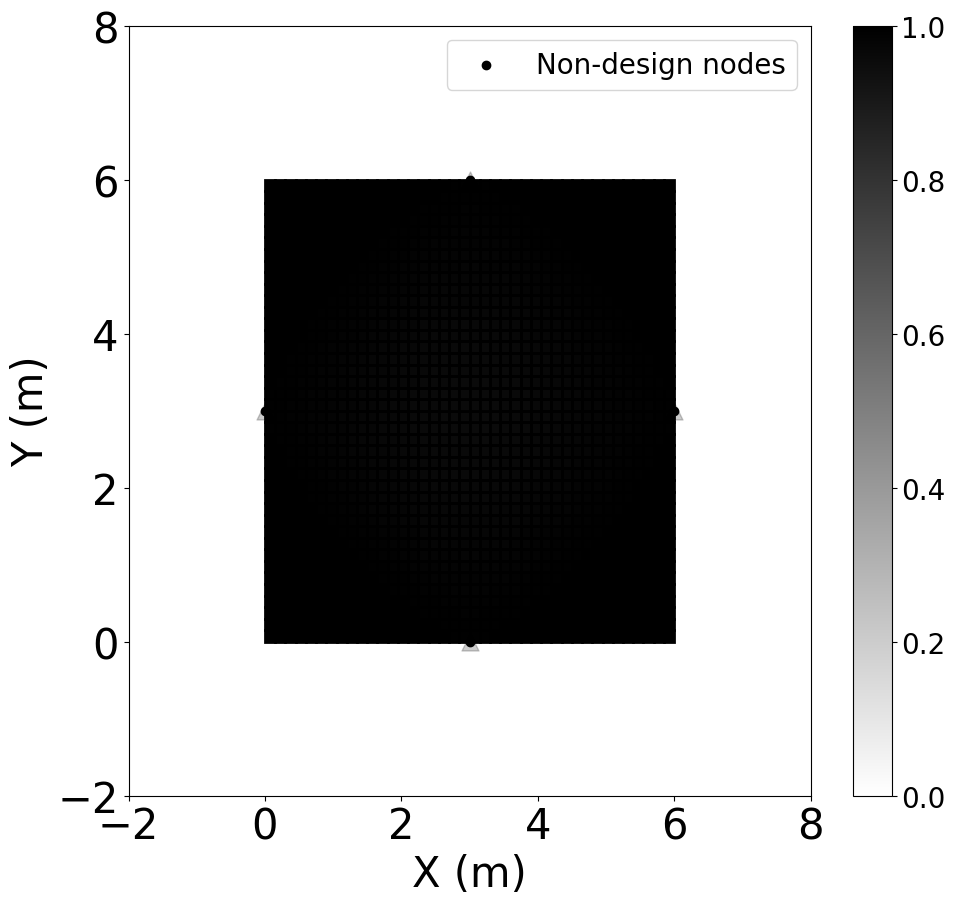

 12%|█▏        | 25/205 [01:50<09:40,  3.23s/it]

Iter25, alpha=1.35, p=3.5


 13%|█▎        | 26/205 [01:52<09:13,  3.09s/it]

Train epoch 27  ,loss:1.5123377319955456
Iter26, alpha=1.4000000000000001, p=3.56


 13%|█▎        | 27/205 [01:55<08:51,  2.99s/it]

Train epoch 28  ,loss:1.5457303849343889
Iter27, alpha=1.4500000000000002, p=3.62


 14%|█▎        | 28/205 [01:58<08:36,  2.92s/it]

Train epoch 29  ,loss:1.5777937676026275
Iter28, alpha=1.5000000000000002, p=3.6799999999999997


 14%|█▍        | 29/205 [02:01<08:24,  2.87s/it]

Train epoch 30  ,loss:1.6075974963080228
Iter29, alpha=1.5500000000000003, p=3.74
Train epoch 31  ,loss:1.6324333330558847
1559.1801585562584


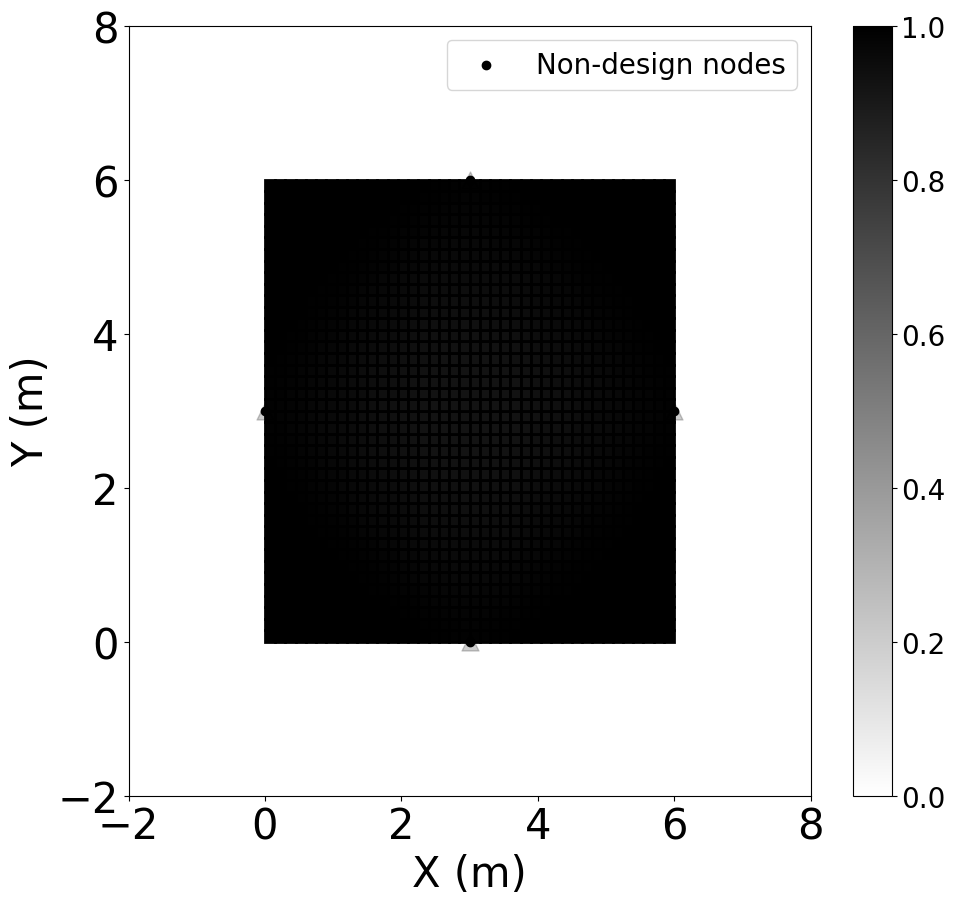

 15%|█▍        | 30/205 [02:05<09:39,  3.31s/it]

Iter30, alpha=1.6, p=3.8


 15%|█▌        | 31/205 [02:08<09:06,  3.14s/it]

Train epoch 32  ,loss:1.6475178632227325
Iter31, alpha=1.6500000000000001, p=3.86


 16%|█▌        | 32/205 [02:11<08:42,  3.02s/it]

Train epoch 33  ,loss:1.647035241464227
Iter32, alpha=1.7000000000000002, p=3.92


 16%|█▌        | 33/205 [02:13<08:24,  2.94s/it]

Train epoch 34  ,loss:1.6226339635494007
Iter33, alpha=1.7500000000000002, p=3.98


 17%|█▋        | 34/205 [02:16<08:11,  2.88s/it]

Train epoch 35  ,loss:1.561900871312765
Iter34, alpha=1.8000000000000003, p=4.04
Train epoch 36  ,loss:1.4494079460652411
1398.1767814882992


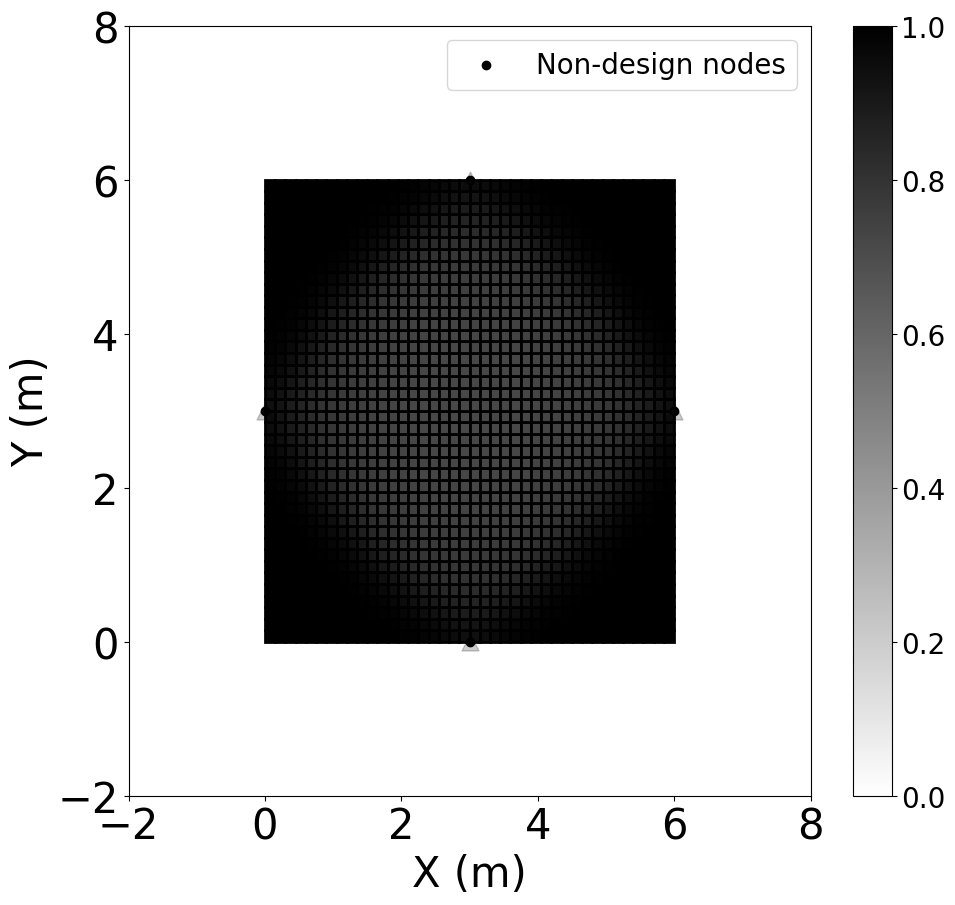

 17%|█▋        | 35/205 [02:20<09:08,  3.23s/it]

Iter35, alpha=1.85, p=4.1


 18%|█▊        | 36/205 [02:23<08:42,  3.09s/it]

Train epoch 37  ,loss:1.2829925394793509
Iter36, alpha=1.9000000000000001, p=4.16


 18%|█▊        | 37/205 [02:26<08:21,  2.99s/it]

Train epoch 38  ,loss:1.0873228671493516
Iter37, alpha=1.9500000000000002, p=4.22


 19%|█▊        | 38/205 [02:28<08:06,  2.91s/it]

Train epoch 39  ,loss:0.9243851266882239
Iter38, alpha=2.0, p=4.279999999999999


 19%|█▉        | 39/205 [02:31<07:55,  2.86s/it]

Train epoch 40  ,loss:0.9059750785920726
Iter39, alpha=2.0500000000000003, p=4.34
Train epoch 41  ,loss:0.8830149269643444
1077.1527493188726


 20%|█▉        | 40/205 [02:35<09:05,  3.31s/it]

Iter40, alpha=2.1, p=4.4


 20%|██        | 41/205 [02:38<08:33,  3.13s/it]

Train epoch 42  ,loss:0.7574044381462053
Iter41, alpha=2.1500000000000004, p=4.46


 20%|██        | 42/205 [02:41<08:09,  3.00s/it]

Train epoch 43  ,loss:0.7152770194263754
Iter42, alpha=2.2, p=4.52


 21%|██        | 43/205 [02:44<07:52,  2.92s/it]

Train epoch 44  ,loss:0.7241190192547893
Iter43, alpha=2.25, p=4.58


 21%|██▏       | 44/205 [02:46<07:39,  2.86s/it]

Train epoch 45  ,loss:0.7428727803410158
Iter44, alpha=2.3000000000000003, p=4.64
Train epoch 46  ,loss:0.7380567134998736
1128.1801444786931


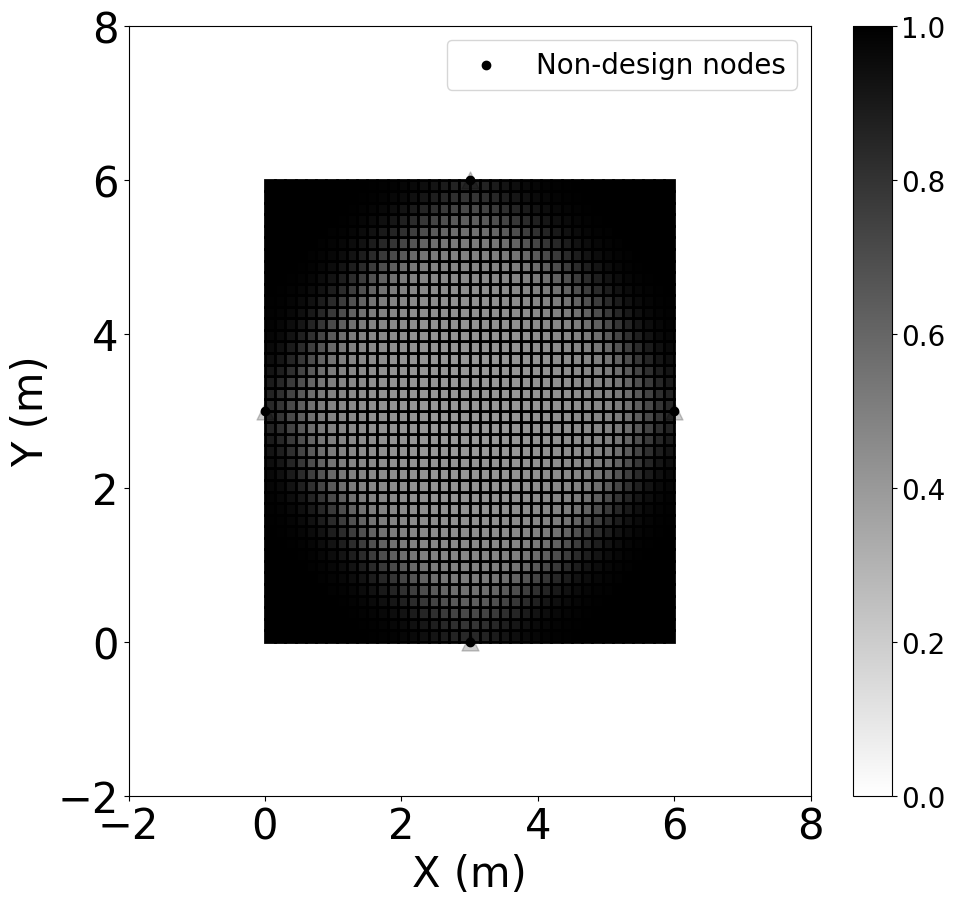

 22%|██▏       | 45/205 [02:50<08:34,  3.22s/it]

Iter45, alpha=2.35, p=4.699999999999999


 22%|██▏       | 46/205 [02:53<08:08,  3.07s/it]

Train epoch 47  ,loss:0.7006981035010073
Iter46, alpha=2.4000000000000004, p=4.76


 23%|██▎       | 47/205 [02:56<07:48,  2.97s/it]

Train epoch 48  ,loss:0.6497882555372839
Iter47, alpha=2.45, p=4.82


 23%|██▎       | 48/205 [02:59<07:35,  2.90s/it]

Train epoch 49  ,loss:0.605922538364768
Iter48, alpha=2.5000000000000004, p=4.88


 24%|██▍       | 49/205 [03:01<07:24,  2.85s/it]

Train epoch 50  ,loss:0.5960689814111433
Iter49, alpha=2.5500000000000003, p=4.9399999999999995
Train epoch 51  ,loss:0.6132290030688123
962.5565201464955


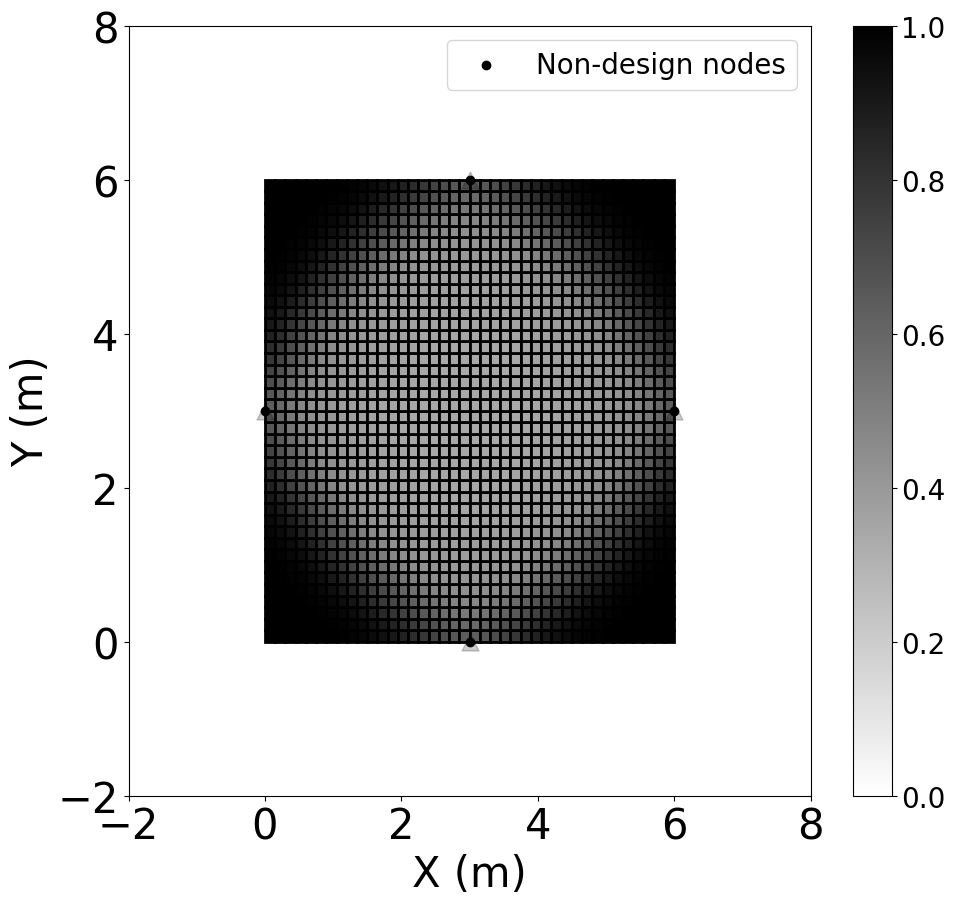

 24%|██▍       | 50/205 [03:05<08:15,  3.20s/it]

Iter50, alpha=2.6, p=5.0


 25%|██▍       | 51/205 [03:08<07:51,  3.06s/it]

Train epoch 52  ,loss:0.6090212060323399
Iter51, alpha=2.6500000000000004, p=5.0600000000000005


 25%|██▌       | 52/205 [03:11<07:32,  2.96s/it]

Train epoch 53  ,loss:0.5825533502302243
Iter52, alpha=2.7, p=5.12


 26%|██▌       | 53/205 [03:13<07:19,  2.89s/it]

Train epoch 54  ,loss:0.56258531552069
Iter53, alpha=2.7500000000000004, p=5.18


 26%|██▋       | 54/205 [03:16<07:09,  2.84s/it]

Train epoch 55  ,loss:0.5607795786729851
Iter54, alpha=2.8000000000000003, p=5.24
Train epoch 56  ,loss:0.568795132799237
1025.7776603058478


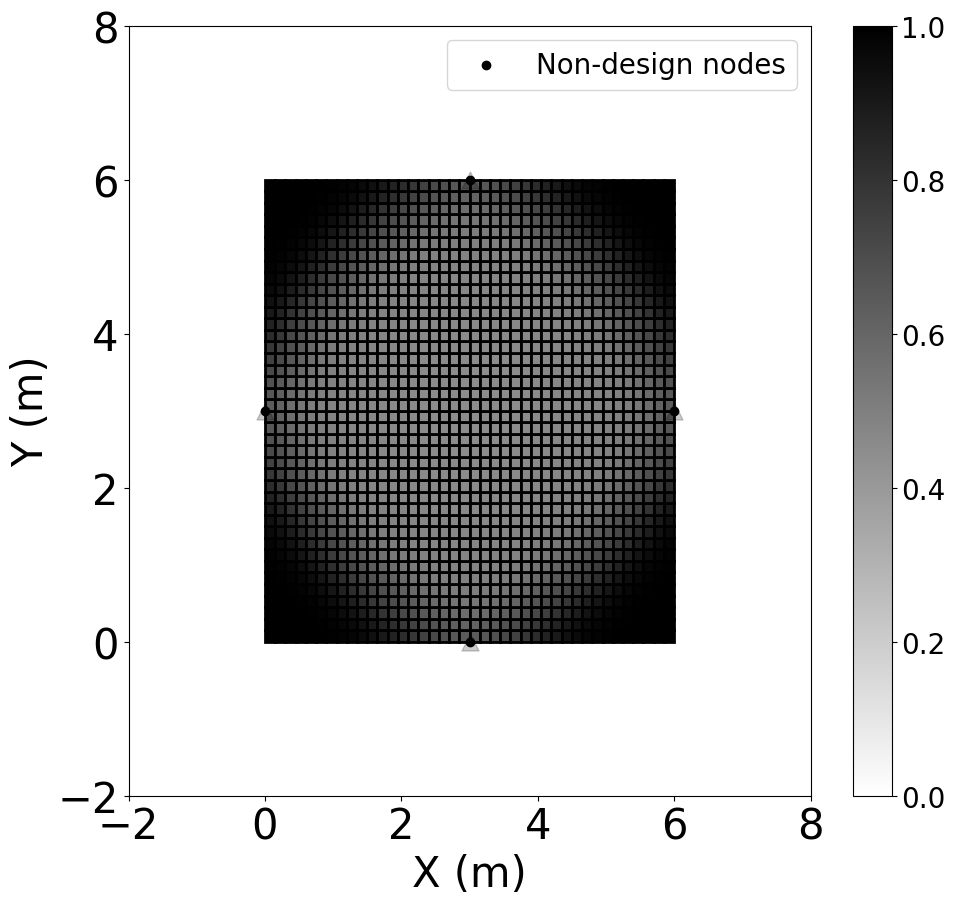

 27%|██▋       | 55/205 [03:21<08:15,  3.31s/it]

Iter55, alpha=2.85, p=5.3


 27%|██▋       | 56/205 [03:23<07:48,  3.14s/it]

Train epoch 57  ,loss:0.5752576388746213
Iter56, alpha=2.9000000000000004, p=5.359999999999999


 28%|██▊       | 57/205 [03:26<07:27,  3.02s/it]

Train epoch 58  ,loss:0.5739968527057343
Iter57, alpha=2.95, p=5.42


 28%|██▊       | 58/205 [03:29<07:10,  2.93s/it]

Train epoch 59  ,loss:0.564556397068156
Iter58, alpha=3.0000000000000004, p=5.48


 29%|██▉       | 59/205 [03:31<06:57,  2.86s/it]

Train epoch 60  ,loss:0.5511188920169959
Iter59, alpha=3.0500000000000003, p=5.54
Train epoch 61  ,loss:0.5426506885315697
969.3883289883186


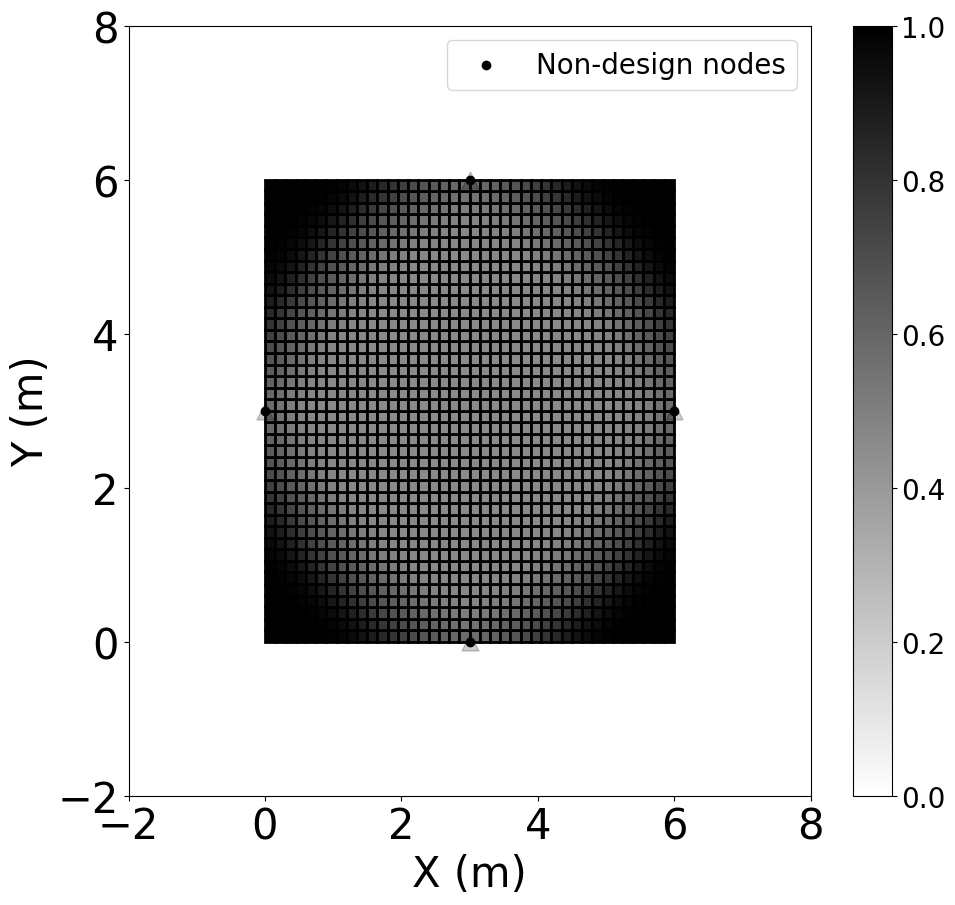

 29%|██▉       | 60/205 [03:35<07:43,  3.20s/it]

Iter60, alpha=3.1, p=5.6


 30%|██▉       | 61/205 [03:38<07:20,  3.06s/it]

Train epoch 62  ,loss:0.5440014238482047
Iter61, alpha=3.1500000000000004, p=5.66


 30%|███       | 62/205 [03:41<07:02,  2.95s/it]

Train epoch 63  ,loss:0.5512912787577956
Iter62, alpha=3.2, p=5.72


 31%|███       | 63/205 [03:44<06:48,  2.88s/it]

Train epoch 64  ,loss:0.5552175670602799
Iter63, alpha=3.2500000000000004, p=5.779999999999999


 31%|███       | 64/205 [03:46<06:38,  2.83s/it]

Train epoch 65  ,loss:0.5516421453901261
Iter64, alpha=3.3000000000000003, p=5.84
Train epoch 66  ,loss:0.547878528746852
984.4969950008713


 32%|███▏      | 65/205 [03:51<07:36,  3.26s/it]

Iter65, alpha=3.35, p=5.9


 32%|███▏      | 66/205 [03:53<07:11,  3.10s/it]

Train epoch 67  ,loss:0.5498735366530954
Iter66, alpha=3.4000000000000004, p=5.96


 33%|███▎      | 67/205 [03:56<06:51,  2.98s/it]

Train epoch 68  ,loss:0.5544868134147738
Iter67, alpha=3.45, p=6.02


 33%|███▎      | 68/205 [03:59<06:36,  2.90s/it]

Train epoch 69  ,loss:0.5567399072319142
Iter68, alpha=3.5000000000000004, p=6.08


 34%|███▎      | 69/205 [04:01<06:26,  2.84s/it]

Train epoch 70  ,loss:0.5550491099815054
Iter69, alpha=3.5500000000000003, p=6.14
Train epoch 71  ,loss:0.5525730117813284
958.742417189645


 34%|███▍      | 70/205 [04:05<07:10,  3.19s/it]

Iter70, alpha=3.6, p=6.2


 35%|███▍      | 71/205 [04:08<06:48,  3.05s/it]

Train epoch 72  ,loss:0.5533132980882765
Iter71, alpha=3.6500000000000004, p=6.26


 35%|███▌      | 72/205 [04:11<06:32,  2.95s/it]

Train epoch 73  ,loss:0.5585017676932574
Iter72, alpha=3.7, p=6.32


 36%|███▌      | 73/205 [04:14<06:19,  2.88s/it]

Train epoch 74  ,loss:0.5650119826173551
Iter73, alpha=3.7500000000000004, p=6.38


 36%|███▌      | 74/205 [04:16<06:11,  2.83s/it]

Train epoch 75  ,loss:0.5682782968476225
Iter74, alpha=3.8000000000000003, p=6.4399999999999995
Train epoch 76  ,loss:0.5690573780760368
962.7882925348455


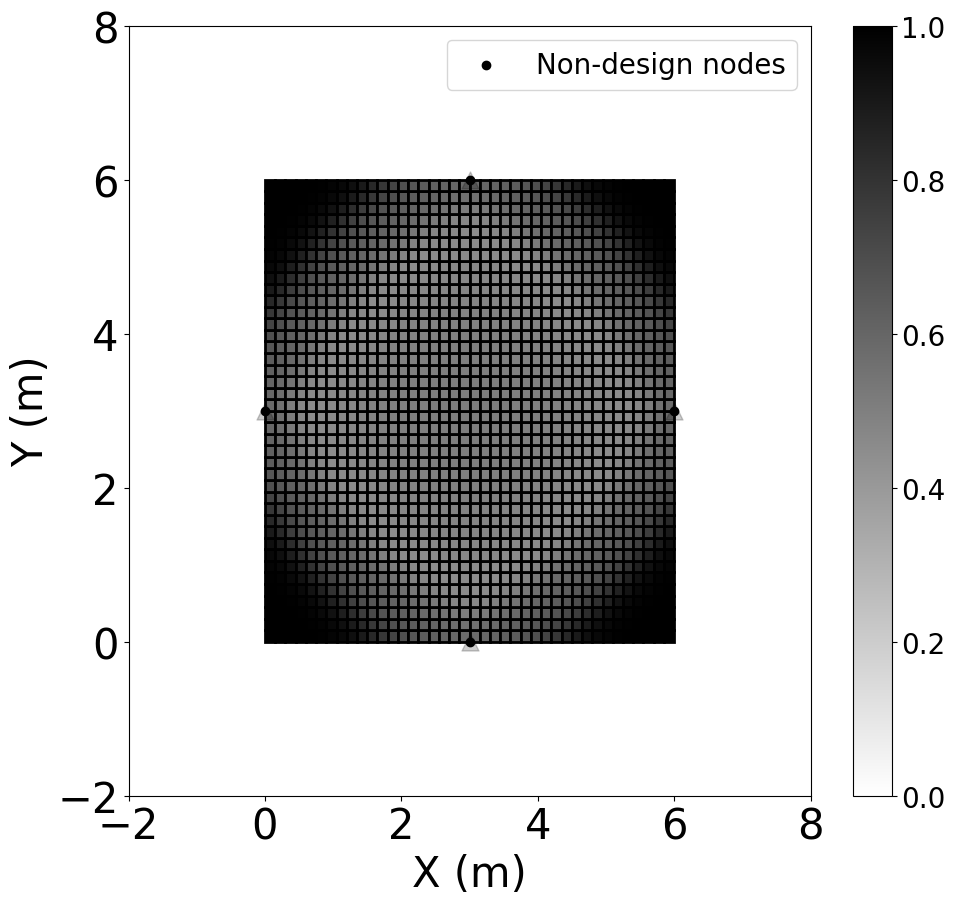

 37%|███▋      | 75/205 [04:21<07:05,  3.27s/it]

Iter75, alpha=3.85, p=6.5


 37%|███▋      | 76/205 [04:23<06:40,  3.11s/it]

Train epoch 77  ,loss:0.5718220908769371
Iter76, alpha=3.9000000000000004, p=6.56


 38%|███▊      | 77/205 [04:26<06:22,  2.99s/it]

Train epoch 78  ,loss:0.5777317839304316
Iter77, alpha=3.95, p=6.62


 38%|███▊      | 78/205 [04:29<06:08,  2.90s/it]

Train epoch 79  ,loss:0.5847224698887116
Iter78, alpha=4.0, p=6.68


 39%|███▊      | 79/205 [04:31<05:57,  2.84s/it]

Train epoch 80  ,loss:0.5901221563298804
Iter79, alpha=4.05, p=6.74
Train epoch 81  ,loss:0.594135957446199
969.2184536751032


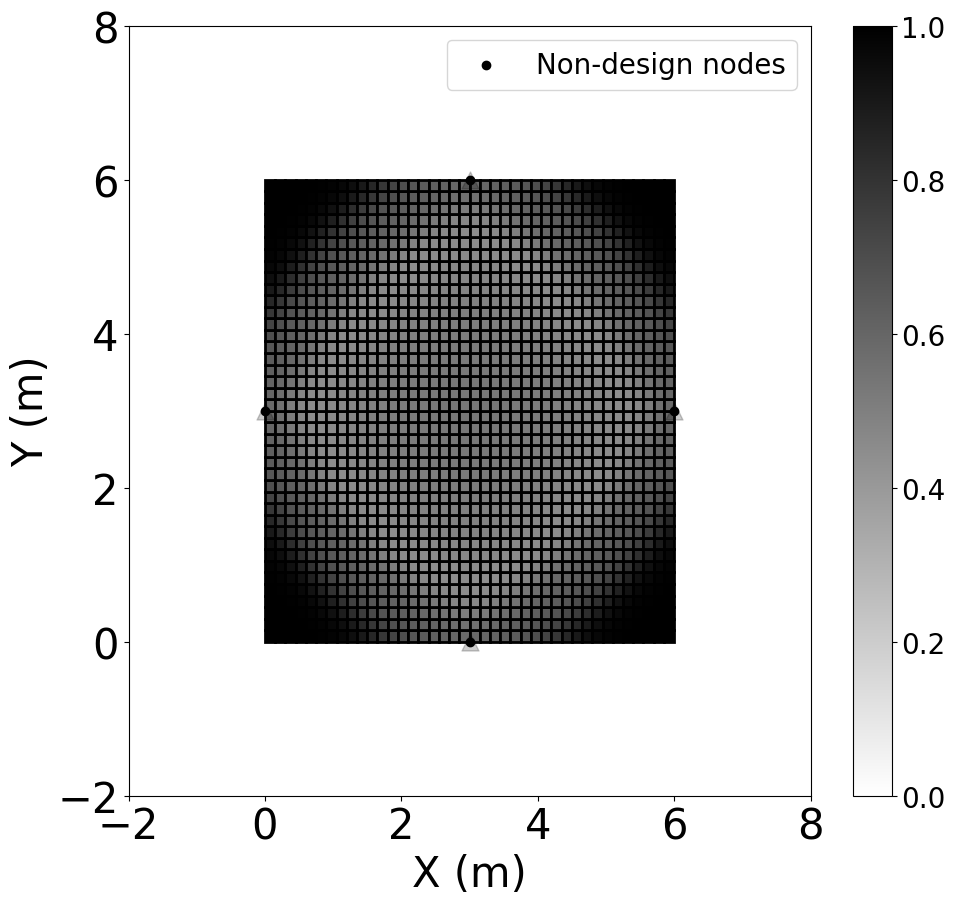

 39%|███▉      | 80/205 [04:35<06:38,  3.19s/it]

Iter80, alpha=4.1, p=6.8


 40%|███▉      | 81/205 [04:38<06:17,  3.04s/it]

Train epoch 82  ,loss:0.5993103870904927
Iter81, alpha=4.1499999999999995, p=6.859999999999999


 40%|████      | 82/205 [04:41<06:01,  2.94s/it]

Train epoch 83  ,loss:0.607120423019565
Iter82, alpha=4.2, p=6.92


 40%|████      | 83/205 [04:44<05:50,  2.87s/it]

Train epoch 84  ,loss:0.6155908899304654
Iter83, alpha=4.25, p=6.9799999999999995


 41%|████      | 84/205 [04:46<05:41,  2.82s/it]

Train epoch 85  ,loss:0.6219845709124145
Iter84, alpha=4.3, p=7.04
Train epoch 86  ,loss:0.6278752564496434
975.0628424708893


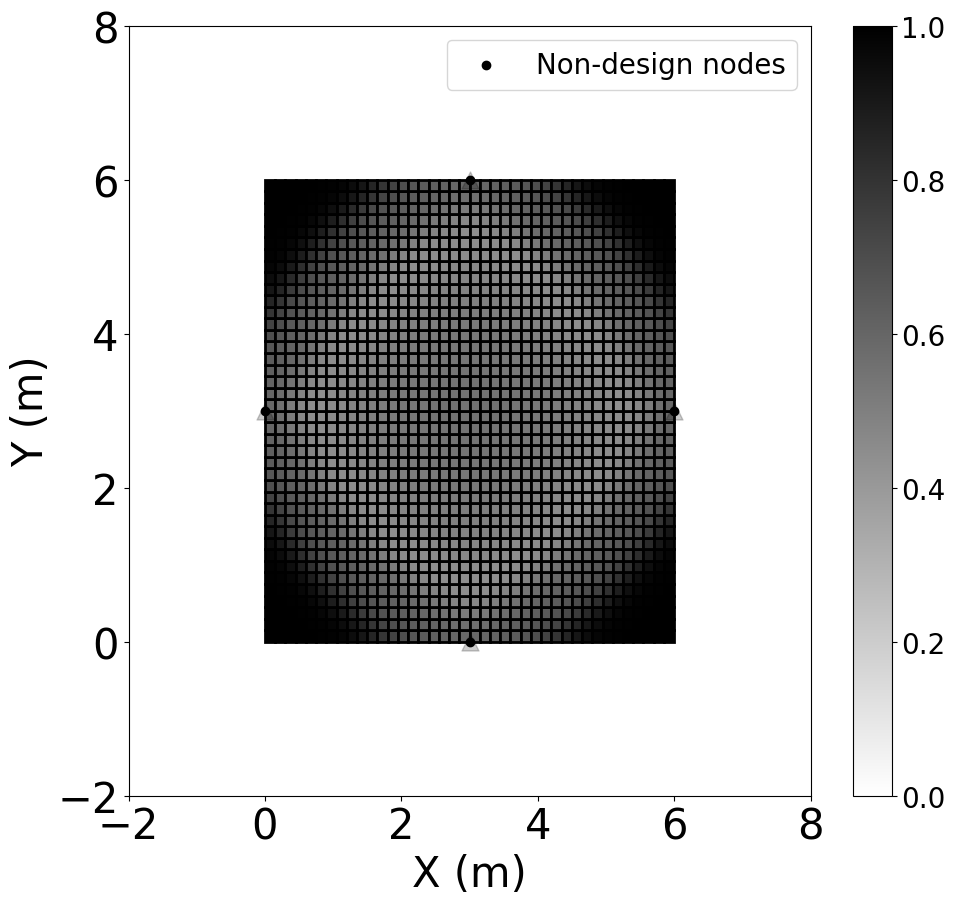

 41%|████▏     | 85/205 [04:51<06:30,  3.26s/it]

Iter85, alpha=4.35, p=7.1


 42%|████▏     | 86/205 [04:53<06:08,  3.10s/it]

Train epoch 87  ,loss:0.6358940706060155
Iter86, alpha=4.3999999999999995, p=7.16


 42%|████▏     | 87/205 [04:56<05:51,  2.98s/it]

Train epoch 88  ,loss:0.6451518598651158
Iter87, alpha=4.45, p=7.22


 43%|████▎     | 88/205 [04:59<05:38,  2.89s/it]

Train epoch 89  ,loss:0.6536911080852061
Iter88, alpha=4.5, p=7.279999999999999


 43%|████▎     | 89/205 [05:01<05:28,  2.83s/it]

Train epoch 90  ,loss:0.6616240662733609
Iter89, alpha=4.55, p=7.34
Train epoch 91  ,loss:0.6705347649508191
967.78838381829


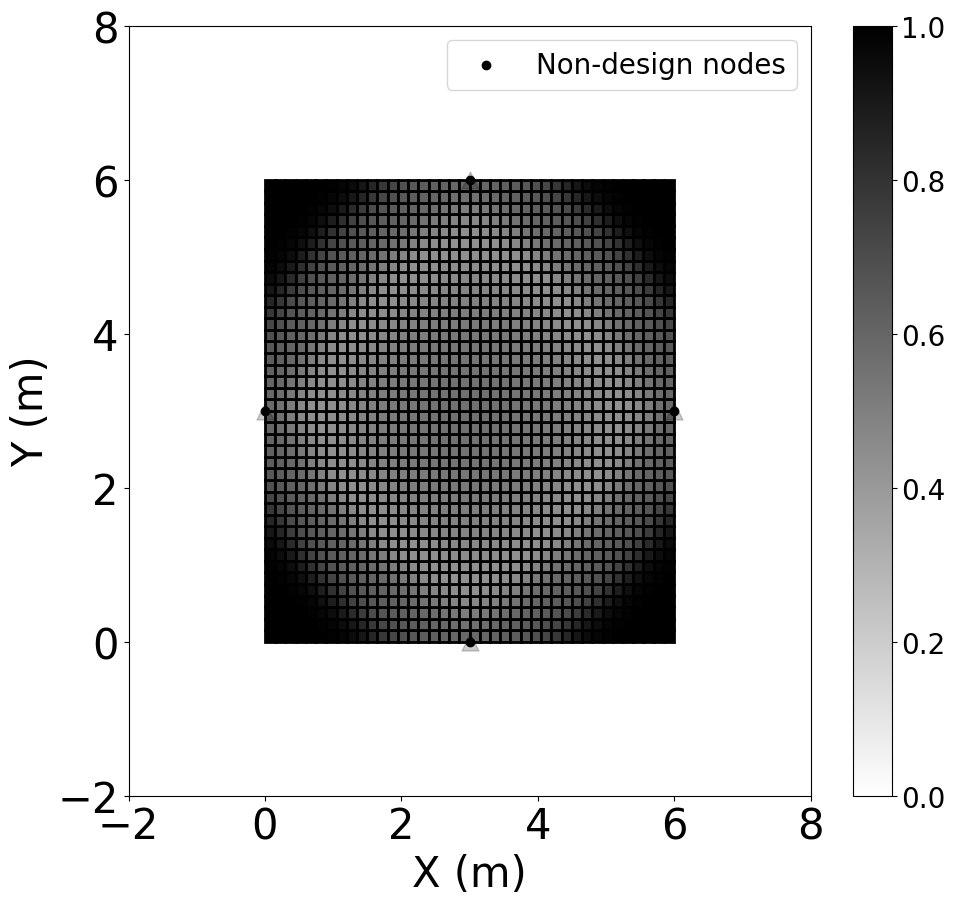

 44%|████▍     | 90/205 [05:05<06:05,  3.18s/it]

Iter90, alpha=4.6, p=7.3999999999999995


 44%|████▍     | 91/205 [05:08<05:46,  3.04s/it]

Train epoch 92  ,loss:0.6803867753908318
Iter91, alpha=4.6499999999999995, p=7.46


 45%|████▍     | 92/205 [05:11<05:31,  2.94s/it]

Train epoch 93  ,loss:0.6893538215084175
Iter92, alpha=4.7, p=7.52


 45%|████▌     | 93/205 [05:13<05:21,  2.87s/it]

Train epoch 94  ,loss:0.6975169711133127
Iter93, alpha=4.75, p=7.58


 46%|████▌     | 94/205 [05:16<05:12,  2.82s/it]

Train epoch 95  ,loss:0.7066004171510282
Iter94, alpha=4.8, p=7.64
Train epoch 96  ,loss:0.716436896666926
986.5661276743751


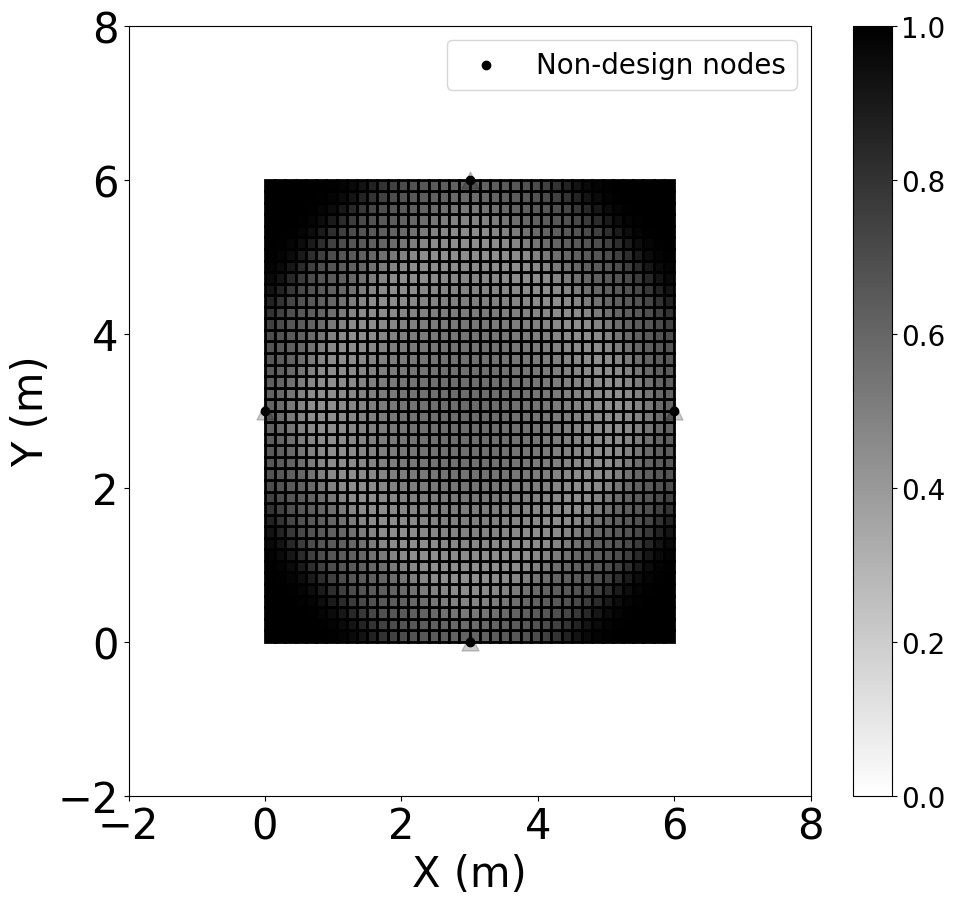

 46%|████▋     | 95/205 [05:20<05:58,  3.26s/it]

Iter95, alpha=4.85, p=7.7


 47%|████▋     | 96/205 [05:23<05:39,  3.11s/it]

Train epoch 97  ,loss:0.7256409781885992
Iter96, alpha=4.9, p=7.76


 47%|████▋     | 97/205 [05:26<05:22,  2.99s/it]

Train epoch 98  ,loss:0.7344749928203224
Iter97, alpha=4.95, p=7.819999999999999


 48%|████▊     | 98/205 [05:29<05:10,  2.90s/it]

Train epoch 99  ,loss:0.7439085528237186
Iter98, alpha=5.0, p=7.88


 48%|████▊     | 99/205 [05:31<05:00,  2.84s/it]

Train epoch 100  ,loss:0.7534257689326677
Iter99, alpha=5.05, p=7.9399999999999995
Train epoch 101  ,loss:0.7621382645601341
987.847624746272


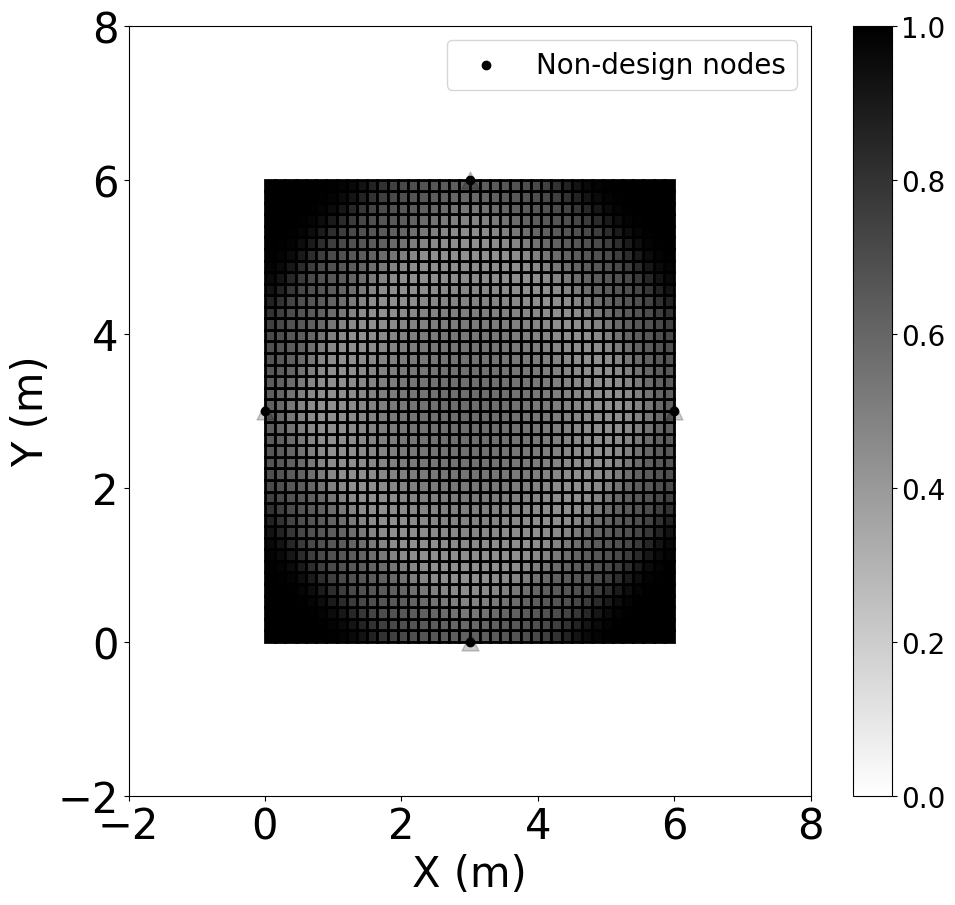

 49%|████▉     | 100/205 [05:35<05:34,  3.19s/it]

Iter100, alpha=5.1, p=8.0


 49%|████▉     | 101/205 [05:38<05:16,  3.04s/it]

Train epoch 102  ,loss:0.7710058327623808
Iter101, alpha=5.15, p=8.0


 50%|████▉     | 102/205 [05:41<05:02,  2.94s/it]

Train epoch 103  ,loss:0.7712945570385481
Iter102, alpha=5.2, p=8.0


 50%|█████     | 103/205 [05:43<04:51,  2.86s/it]

Train epoch 104  ,loss:0.7707198825893476
Iter103, alpha=5.25, p=8.0


 51%|█████     | 104/205 [05:46<04:43,  2.81s/it]

Train epoch 105  ,loss:0.7688637015242888
Iter104, alpha=5.3, p=8.0
Train epoch 106  ,loss:0.7677521378524719
974.564062772535


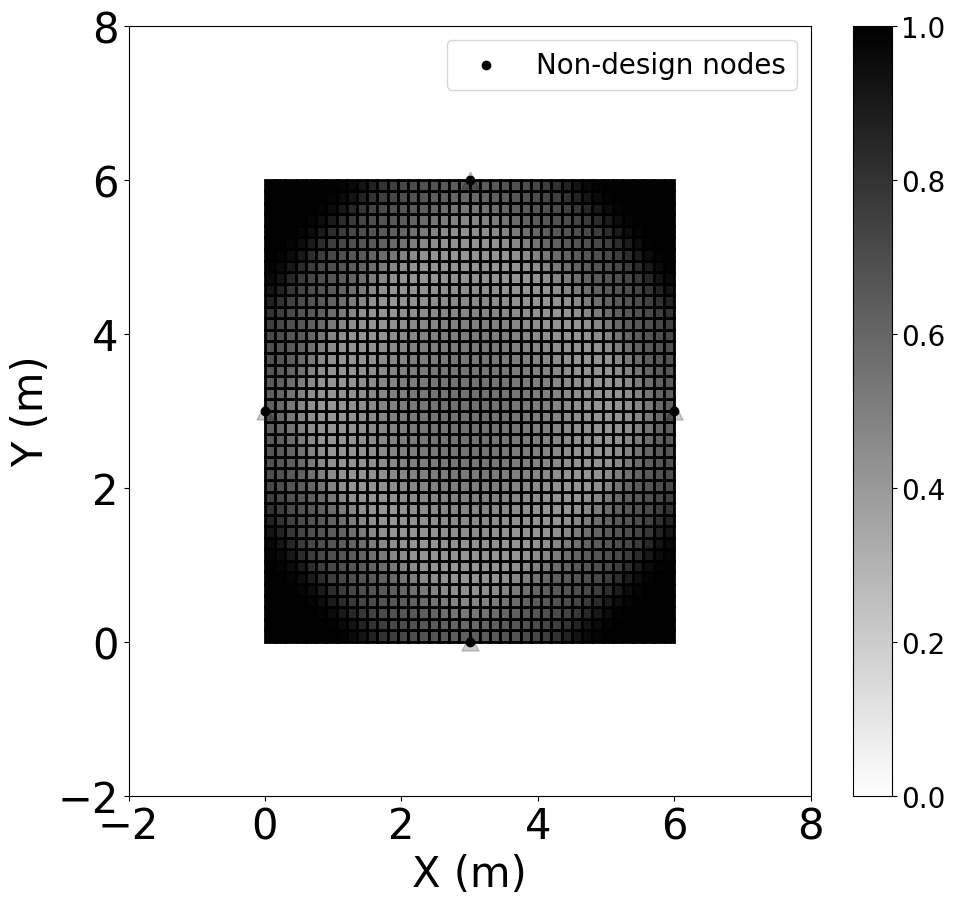

 51%|█████     | 105/205 [05:50<05:25,  3.25s/it]

Iter105, alpha=5.35, p=8.0


 52%|█████▏    | 106/205 [05:53<05:05,  3.09s/it]

Train epoch 107  ,loss:0.7666948954220969
Iter106, alpha=5.4, p=8.0


 52%|█████▏    | 107/205 [05:56<04:51,  2.97s/it]

Train epoch 108  ,loss:0.7640411350483248
Iter107, alpha=5.45, p=8.0


 53%|█████▎    | 108/205 [05:58<04:40,  2.89s/it]

Train epoch 109  ,loss:0.7613624124409313
Iter108, alpha=5.5, p=8.0


 53%|█████▎    | 109/205 [06:01<04:31,  2.83s/it]

Train epoch 110  ,loss:0.7588532481316425
Iter109, alpha=5.55, p=8.0
Train epoch 111  ,loss:0.7550204125958045
971.5974374223514


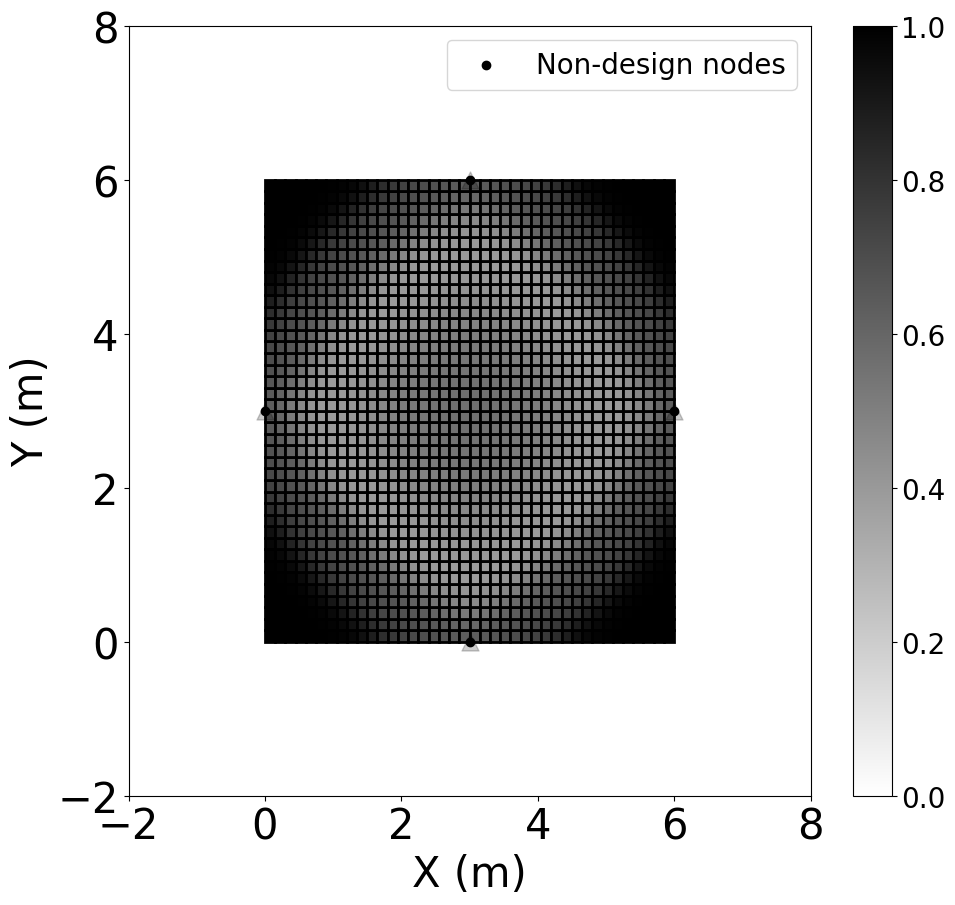

 54%|█████▎    | 110/205 [06:05<05:02,  3.18s/it]

Iter110, alpha=5.6, p=8.0


 54%|█████▍    | 111/205 [06:08<04:45,  3.04s/it]

Train epoch 112  ,loss:0.7505189423889999
Iter111, alpha=5.65, p=8.0


 55%|█████▍    | 112/205 [06:11<04:33,  2.94s/it]

Train epoch 113  ,loss:0.7458536262791743
Iter112, alpha=5.7, p=8.0


 55%|█████▌    | 113/205 [06:13<04:23,  2.87s/it]

Train epoch 114  ,loss:0.7398495653750893
Iter113, alpha=5.75, p=8.0


 56%|█████▌    | 114/205 [06:16<04:16,  2.82s/it]

Train epoch 115  ,loss:0.7329479914466699
Iter114, alpha=5.8, p=8.0
Train epoch 116  ,loss:0.725614619366773
962.7248158781214


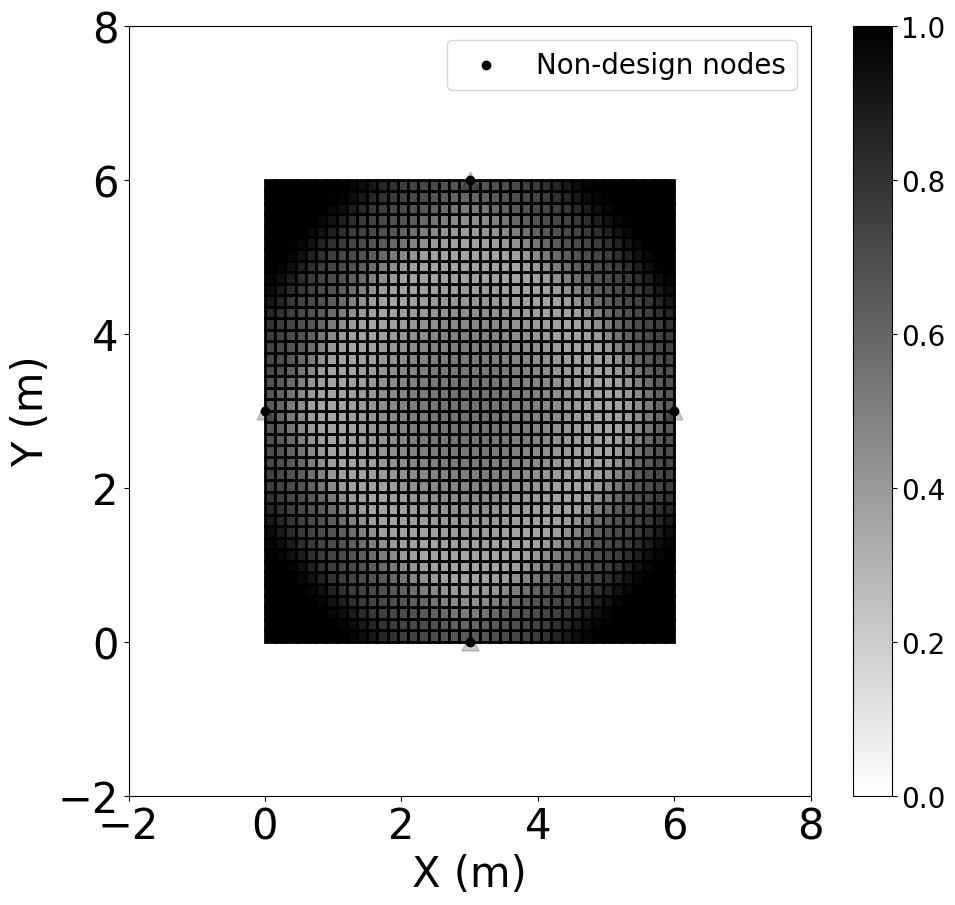

 56%|█████▌    | 115/205 [06:20<04:52,  3.25s/it]

Iter115, alpha=5.85, p=8.0


 57%|█████▋    | 116/205 [06:23<04:35,  3.09s/it]

Train epoch 117  ,loss:0.7168613907365342
Iter116, alpha=5.9, p=8.0


 57%|█████▋    | 117/205 [06:26<04:21,  2.97s/it]

Train epoch 118  ,loss:0.7072050116259484
Iter117, alpha=5.95, p=8.0


 58%|█████▊    | 118/205 [06:28<04:11,  2.89s/it]

Train epoch 119  ,loss:0.6973049966061702
Iter118, alpha=6.0, p=8.0


 58%|█████▊    | 119/205 [06:31<04:04,  2.84s/it]

Train epoch 120  ,loss:0.6868092226923685
Iter119, alpha=6.05, p=8.0
Train epoch 121  ,loss:0.6761002996477382
949.1013689190322


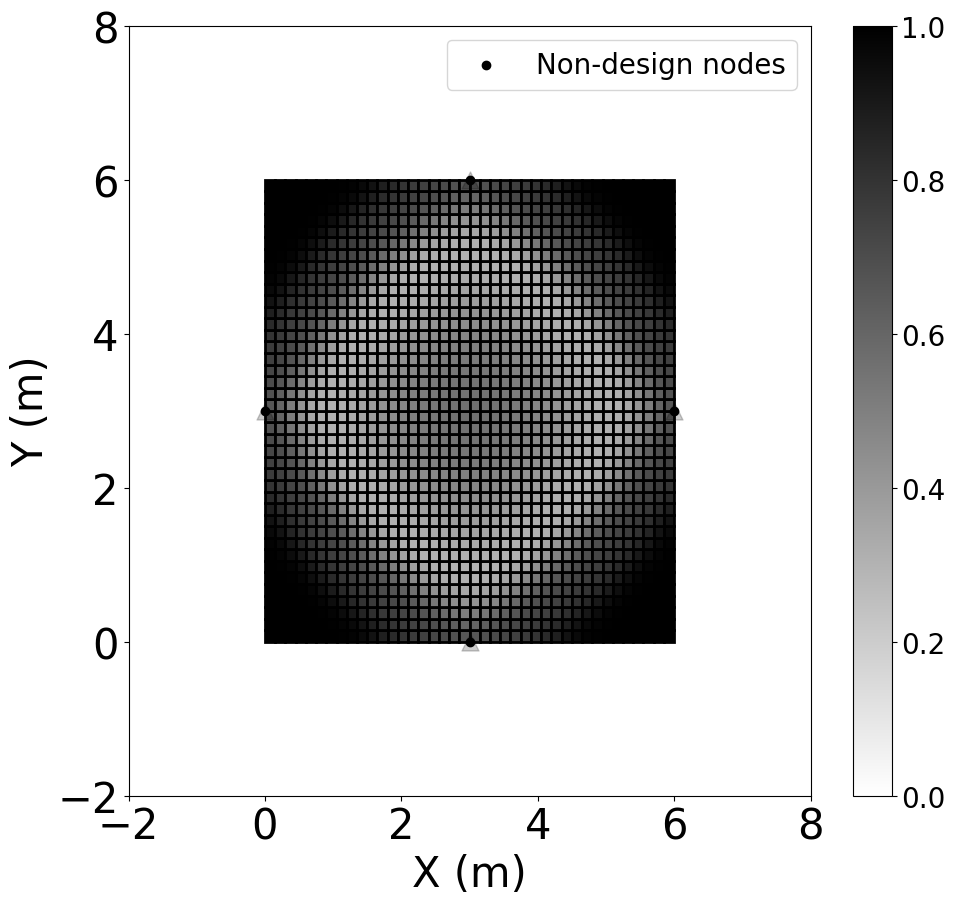

 59%|█████▊    | 120/205 [06:35<04:31,  3.19s/it]

Iter120, alpha=6.1, p=8.0


 59%|█████▉    | 121/205 [06:38<04:15,  3.04s/it]

Train epoch 122  ,loss:0.6659790042749828
Iter121, alpha=6.15, p=8.0


 60%|█████▉    | 122/205 [06:40<04:04,  2.94s/it]

Train epoch 123  ,loss:0.6562186628260237
Iter122, alpha=6.2, p=8.0


 60%|██████    | 123/205 [06:43<03:55,  2.87s/it]

Train epoch 124  ,loss:0.6478494551783136
Iter123, alpha=6.25, p=8.0


 60%|██████    | 124/205 [06:46<03:48,  2.82s/it]

Train epoch 125  ,loss:0.6411565628095044
Iter124, alpha=6.3, p=8.0
Train epoch 126  ,loss:0.6361307522043291
943.5105568360223


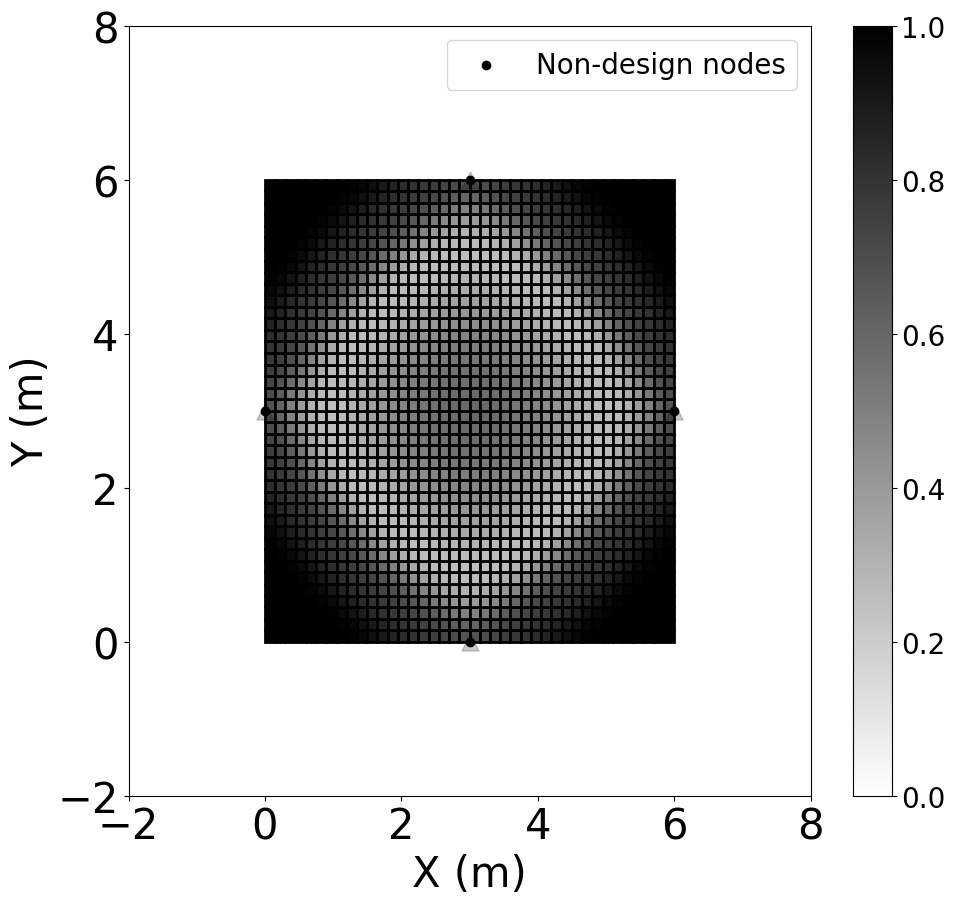

 61%|██████    | 125/205 [06:50<04:21,  3.26s/it]

Iter125, alpha=6.35, p=8.0


 61%|██████▏   | 126/205 [06:53<04:04,  3.09s/it]

Train epoch 127  ,loss:0.6338321125758455
Iter126, alpha=6.4, p=8.0


 62%|██████▏   | 127/205 [06:56<03:51,  2.96s/it]

Train epoch 128  ,loss:0.6336425694350916
Iter127, alpha=6.45, p=8.0


 62%|██████▏   | 128/205 [06:58<03:41,  2.88s/it]

Train epoch 129  ,loss:0.6351664584583866
Iter128, alpha=6.5, p=8.0


 63%|██████▎   | 129/205 [07:01<03:33,  2.82s/it]

Train epoch 130  ,loss:0.6375929060492868
Iter129, alpha=6.55, p=8.0
Train epoch 131  ,loss:0.6397636830658017
947.8324309532431


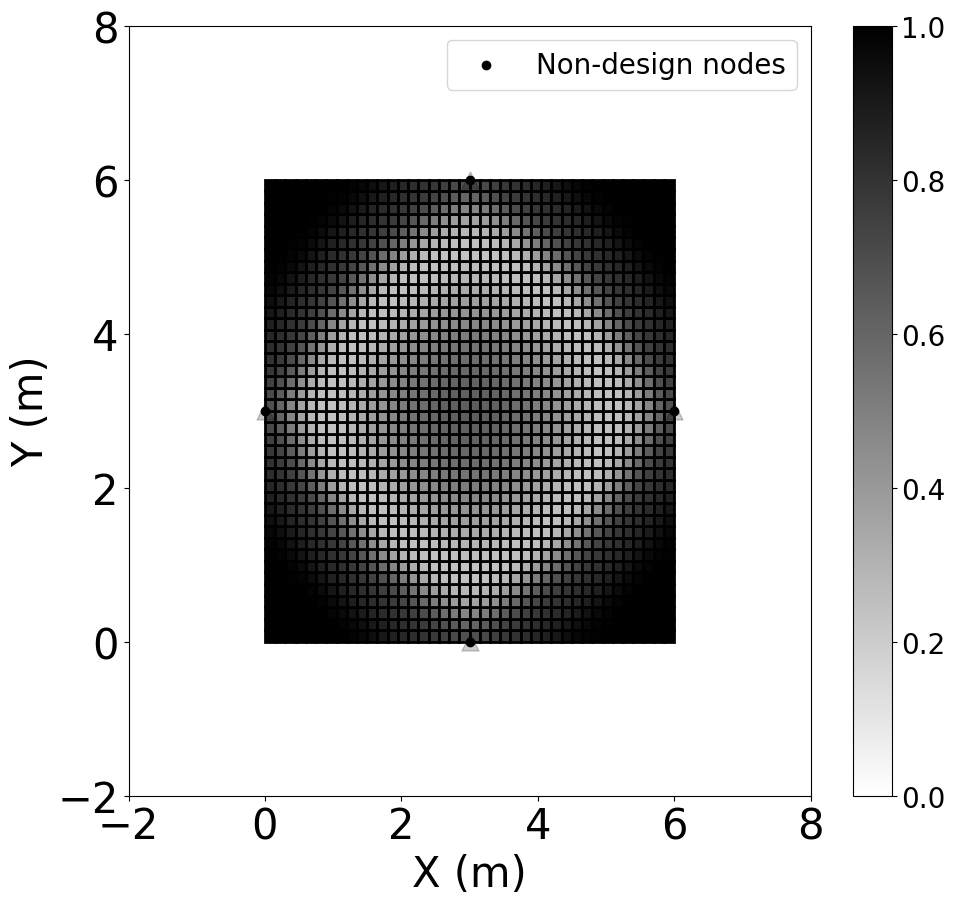

 63%|██████▎   | 130/205 [07:05<03:57,  3.16s/it]

Iter130, alpha=6.6, p=8.0


 64%|██████▍   | 131/205 [07:08<03:43,  3.02s/it]

Train epoch 132  ,loss:0.6412110691127825
Iter131, alpha=6.65, p=8.0


 64%|██████▍   | 132/205 [07:10<03:33,  2.92s/it]

Train epoch 133  ,loss:0.6408643321546987
Iter132, alpha=6.7, p=8.0


 65%|██████▍   | 133/205 [07:13<03:25,  2.86s/it]

Train epoch 134  ,loss:0.6388224009957364
Iter133, alpha=6.75, p=8.0


 65%|██████▌   | 134/205 [07:16<03:19,  2.81s/it]

Train epoch 135  ,loss:0.6348799473151482
Iter134, alpha=6.8, p=8.0
Train epoch 136  ,loss:0.6301409778468159
938.5389284621317


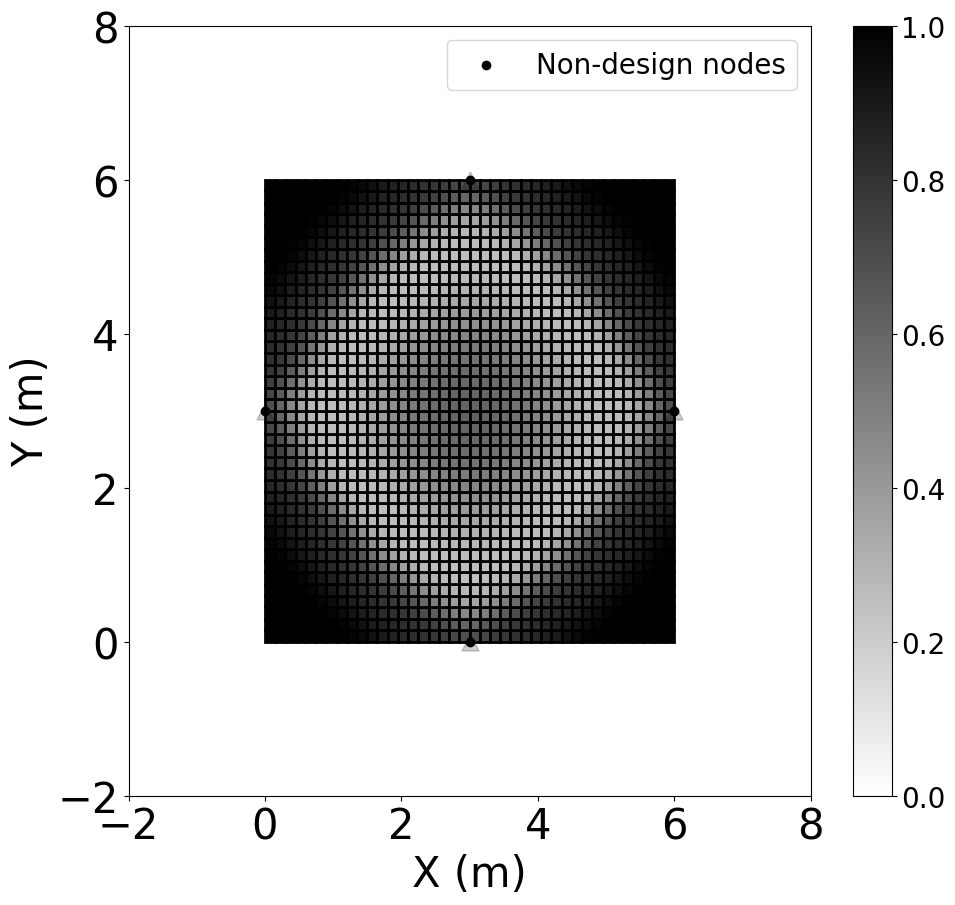

 66%|██████▌   | 135/205 [07:20<03:47,  3.25s/it]

Iter135, alpha=6.85, p=8.0


 66%|██████▋   | 136/205 [07:23<03:33,  3.09s/it]

Train epoch 137  ,loss:0.6253557497754239
Iter136, alpha=6.9, p=8.0


 67%|██████▋   | 137/205 [07:25<03:22,  2.98s/it]

Train epoch 138  ,loss:0.6215914276012312
Iter137, alpha=6.95, p=8.0


 67%|██████▋   | 138/205 [07:28<03:14,  2.90s/it]

Train epoch 139  ,loss:0.6191392607823637
Iter138, alpha=7.0, p=8.0


 68%|██████▊   | 139/205 [07:31<03:07,  2.84s/it]

Train epoch 140  ,loss:0.6177772438350843
Iter139, alpha=7.05, p=8.0
Train epoch 141  ,loss:0.6174918095069504
929.0785849298185


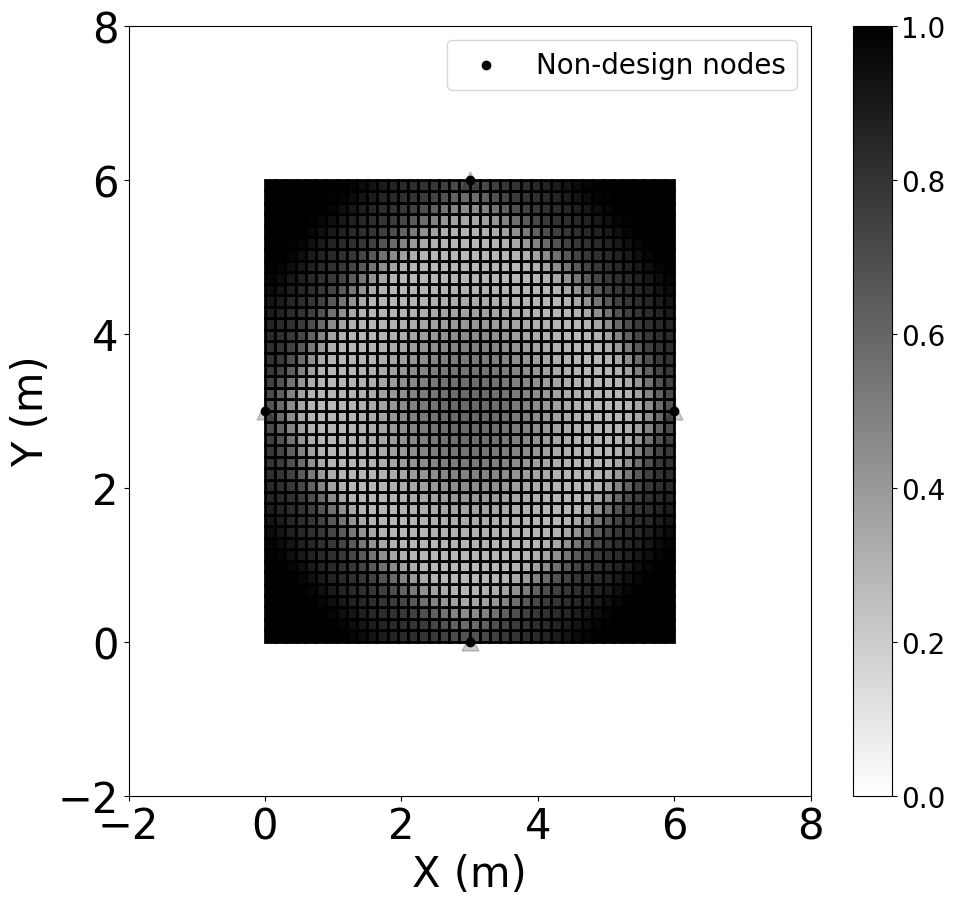

 68%|██████▊   | 140/205 [07:35<03:27,  3.20s/it]

Iter140, alpha=7.1, p=8.0


 69%|██████▉   | 141/205 [07:38<03:15,  3.05s/it]

Train epoch 142  ,loss:0.617521187667783
Iter141, alpha=7.15, p=8.0


 69%|██████▉   | 142/205 [07:40<03:05,  2.95s/it]

Train epoch 143  ,loss:0.6177669782359588
Iter142, alpha=7.2, p=8.0


 70%|██████▉   | 143/205 [07:43<02:58,  2.87s/it]

Train epoch 144  ,loss:0.6177634792747894
Iter143, alpha=7.25, p=8.0


 70%|███████   | 144/205 [07:46<02:52,  2.83s/it]

Train epoch 145  ,loss:0.6174841324235976
Iter144, alpha=7.3, p=8.0
Train epoch 146  ,loss:0.6167177323043612
924.1232821423212


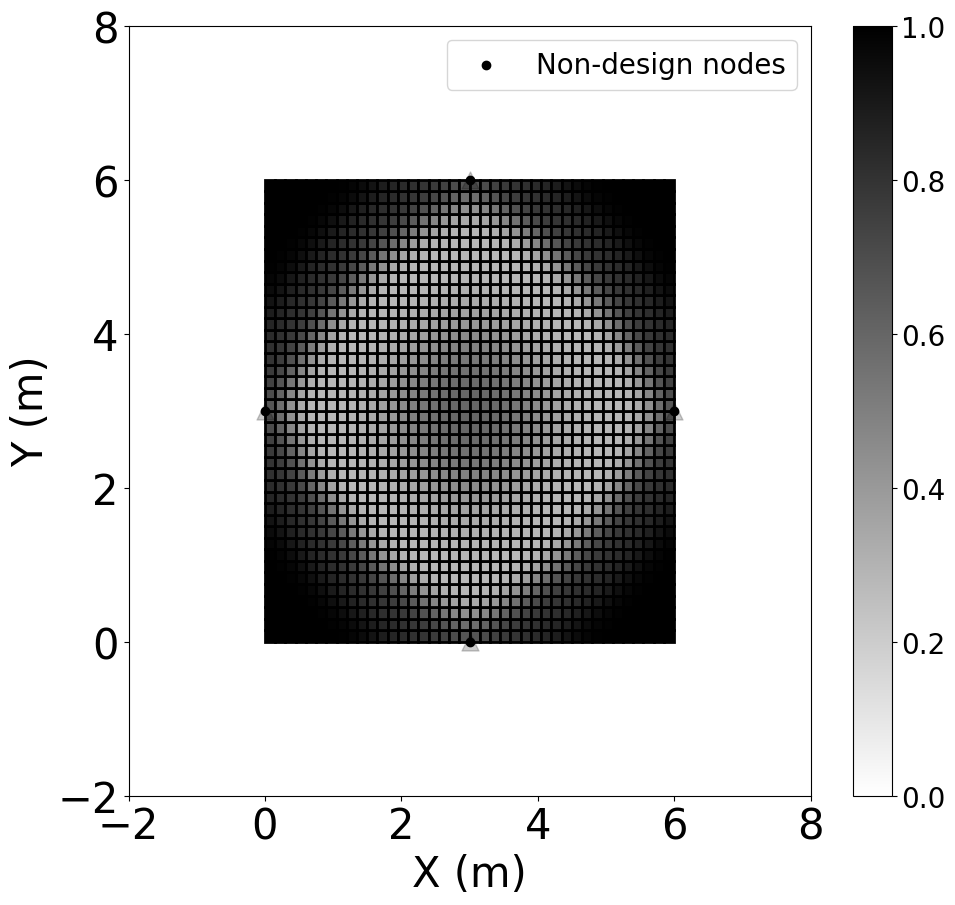

 71%|███████   | 145/205 [07:50<03:16,  3.28s/it]

Iter145, alpha=7.35, p=8.0


 71%|███████   | 146/205 [07:53<03:02,  3.10s/it]

Train epoch 147  ,loss:0.6156558087185485
Iter146, alpha=7.4, p=8.0


 72%|███████▏  | 147/205 [07:55<02:52,  2.97s/it]

Train epoch 148  ,loss:0.614248787324277
Iter147, alpha=7.45, p=8.0


 72%|███████▏  | 148/205 [07:58<02:44,  2.88s/it]

Train epoch 149  ,loss:0.6127721731326623
Iter148, alpha=7.5, p=8.0


 73%|███████▎  | 149/205 [08:01<02:37,  2.82s/it]

Train epoch 150  ,loss:0.6114624066501749
Iter149, alpha=7.55, p=8.0
Train epoch 151  ,loss:0.6105252746568023
921.2415127327672


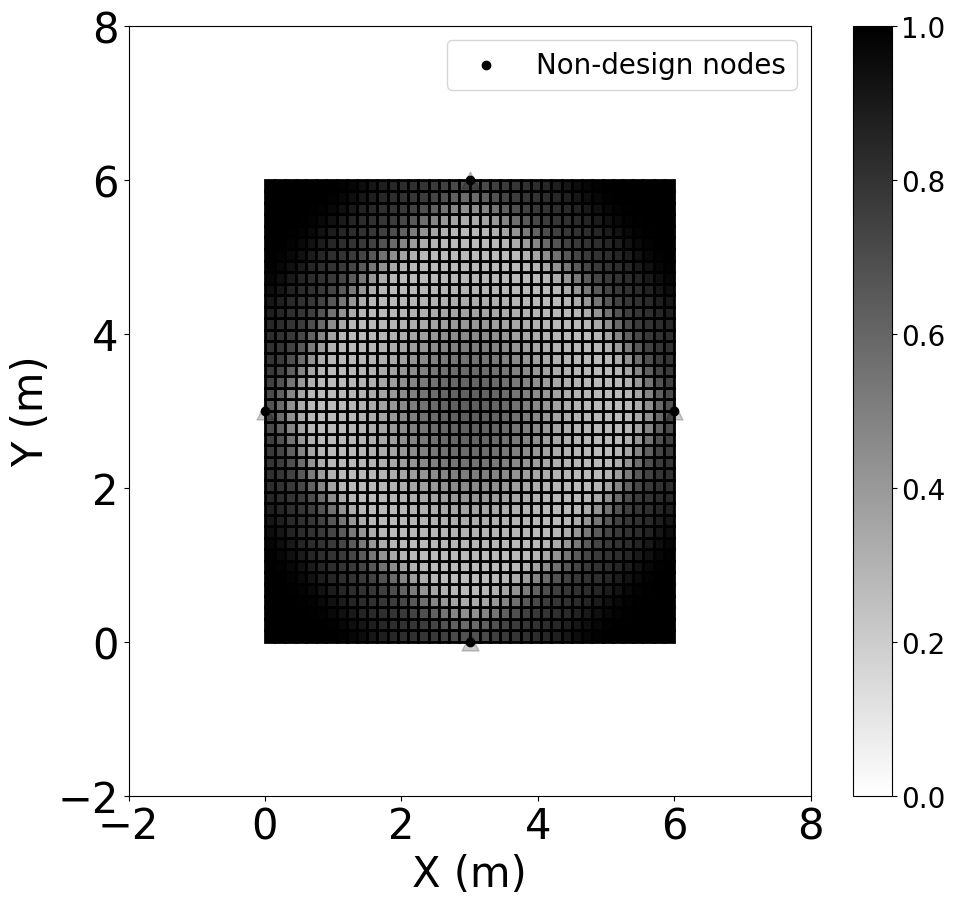

 73%|███████▎  | 150/205 [08:05<02:53,  3.16s/it]

Iter150, alpha=7.6, p=8.0


 74%|███████▎  | 151/205 [08:07<02:43,  3.02s/it]

Train epoch 152  ,loss:0.6097954119949598
Iter151, alpha=7.65, p=8.0


 74%|███████▍  | 152/205 [08:10<02:36,  2.95s/it]

Train epoch 153  ,loss:0.6091314908171114
Iter152, alpha=7.7, p=8.0


 75%|███████▍  | 153/205 [08:13<02:29,  2.87s/it]

Train epoch 154  ,loss:0.6083926223826331
Iter153, alpha=7.75, p=8.0


 75%|███████▌  | 154/205 [08:15<02:23,  2.82s/it]

Train epoch 155  ,loss:0.6077334054539338
Iter154, alpha=7.8, p=8.0
Train epoch 156  ,loss:0.6071984811698534
919.9880874850533


 76%|███████▌  | 155/205 [08:19<02:38,  3.18s/it]

Iter155, alpha=7.85, p=8.0


 76%|███████▌  | 156/205 [08:22<02:29,  3.05s/it]

Train epoch 157  ,loss:0.606792118118473
Iter156, alpha=7.9, p=8.0


 77%|███████▋  | 157/205 [08:25<02:21,  2.95s/it]

Train epoch 158  ,loss:0.606476590416957
Iter157, alpha=7.95, p=8.0


 77%|███████▋  | 158/205 [08:28<02:15,  2.88s/it]

Train epoch 159  ,loss:0.606250862093239
Iter158, alpha=8.0, p=8.0


 78%|███████▊  | 159/205 [08:30<02:09,  2.83s/it]

Train epoch 160  ,loss:0.6059820203514793
Iter159, alpha=8.05, p=8.0
Train epoch 161  ,loss:0.6056105604207841
915.1479425046483


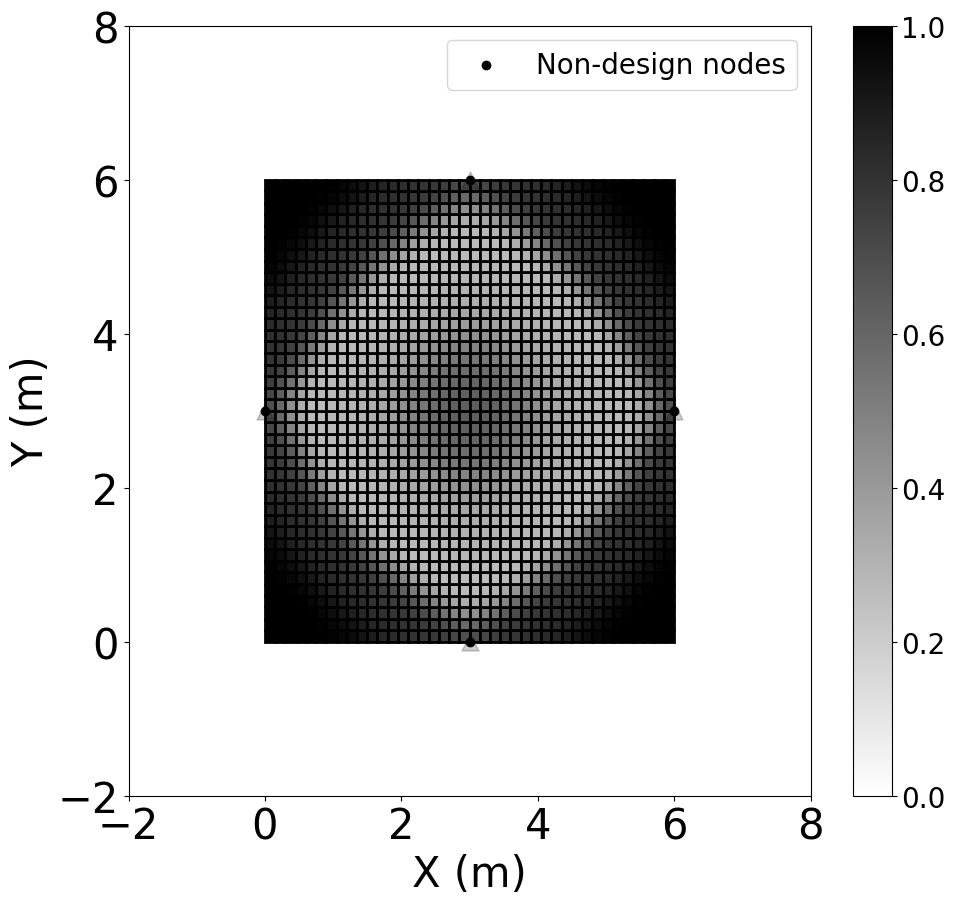

 78%|███████▊  | 160/205 [08:35<02:27,  3.28s/it]

Iter160, alpha=8.1, p=8.0


 79%|███████▊  | 161/205 [08:37<02:16,  3.11s/it]

Train epoch 162  ,loss:0.6050720378222483
Iter161, alpha=8.15, p=8.0


 79%|███████▉  | 162/205 [08:40<02:08,  2.98s/it]

Train epoch 163  ,loss:0.6045508046952289
Iter162, alpha=8.2, p=8.0


 80%|███████▉  | 163/205 [08:43<02:01,  2.90s/it]

Train epoch 164  ,loss:0.6041084482362242
Iter163, alpha=8.25, p=8.0


 80%|████████  | 164/205 [08:46<01:56,  2.84s/it]

Train epoch 165  ,loss:0.6038295028791039
Iter164, alpha=8.3, p=8.0
Train epoch 166  ,loss:0.6037313985685403
912.4019440032496


 80%|████████  | 165/205 [08:50<02:07,  3.19s/it]

Iter165, alpha=8.35, p=8.0


 81%|████████  | 166/205 [08:52<01:58,  3.04s/it]

Train epoch 167  ,loss:0.603705945864027
Iter166, alpha=8.4, p=8.0


 81%|████████▏ | 167/205 [08:55<01:52,  2.95s/it]

Train epoch 168  ,loss:0.603690863405764
Iter167, alpha=8.45, p=8.0


 82%|████████▏ | 168/205 [08:58<01:46,  2.88s/it]

Train epoch 169  ,loss:0.603566392959846
Iter168, alpha=8.5, p=8.0


 82%|████████▏ | 169/205 [09:00<01:41,  2.82s/it]

Train epoch 170  ,loss:0.6033596738774628
Iter169, alpha=8.55, p=8.0
Train epoch 171  ,loss:0.6031334977403348
910.348453205372


 83%|████████▎ | 170/205 [09:05<01:53,  3.25s/it]

Iter170, alpha=8.6, p=8.0


 83%|████████▎ | 171/205 [09:07<01:45,  3.09s/it]

Train epoch 172  ,loss:0.6029268334578253
Iter171, alpha=8.65, p=8.0


 84%|████████▍ | 172/205 [09:10<01:38,  2.97s/it]

Train epoch 173  ,loss:0.6028088384943355
Iter172, alpha=8.7, p=8.0


 84%|████████▍ | 173/205 [09:13<01:32,  2.89s/it]

Train epoch 174  ,loss:0.6028042182217006
Iter173, alpha=8.75, p=8.0


 85%|████████▍ | 174/205 [09:15<01:27,  2.83s/it]

Train epoch 175  ,loss:0.6028368638801633
Iter174, alpha=8.8, p=8.0
Train epoch 176  ,loss:0.6028819515523808
908.3797296540754


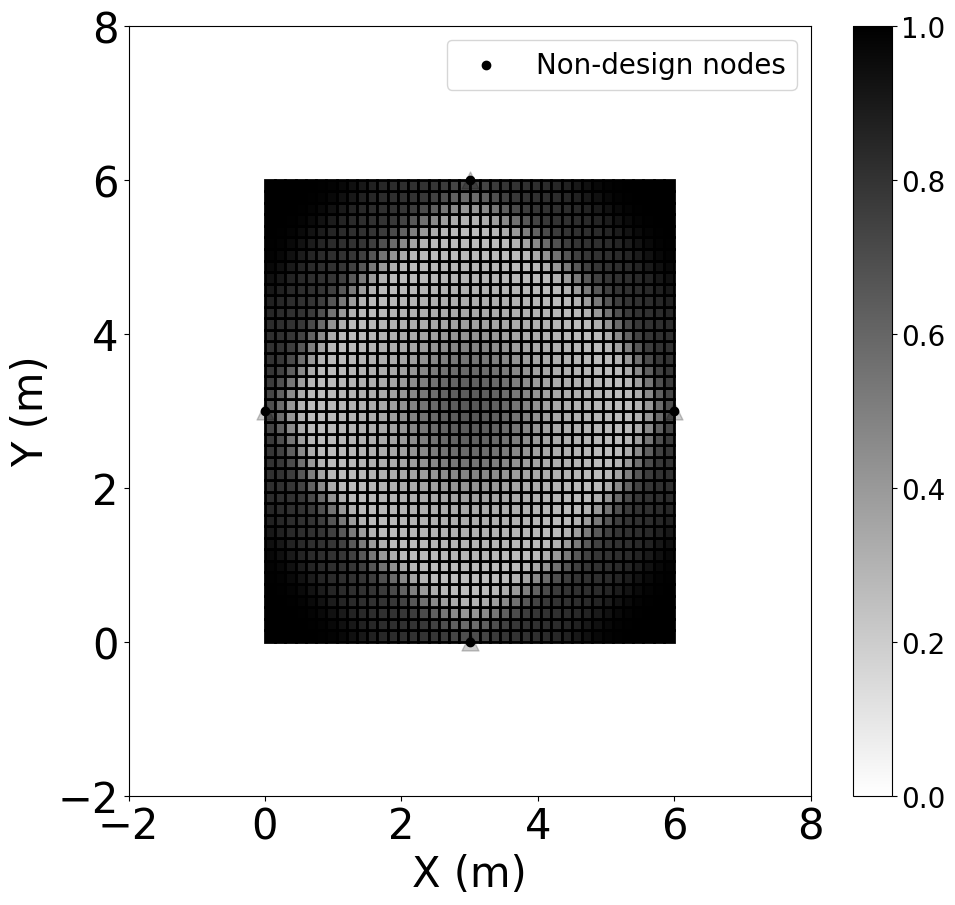

 85%|████████▌ | 175/205 [09:19<01:35,  3.19s/it]

Iter175, alpha=8.85, p=8.0


 86%|████████▌ | 176/205 [09:22<01:28,  3.04s/it]

Train epoch 177  ,loss:0.6028868827745971
Iter176, alpha=8.9, p=8.0


 86%|████████▋ | 177/205 [09:25<01:22,  2.95s/it]

Train epoch 178  ,loss:0.6028751732795851
Iter177, alpha=8.95, p=8.0


 87%|████████▋ | 178/205 [09:28<01:17,  2.87s/it]

Train epoch 179  ,loss:0.6028729706516324
Iter178, alpha=9.0, p=8.0


 87%|████████▋ | 179/205 [09:30<01:13,  2.82s/it]

Train epoch 180  ,loss:0.6028625226985682
Iter179, alpha=9.05, p=8.0
Train epoch 181  ,loss:0.6028753423376295
905.5930171602113


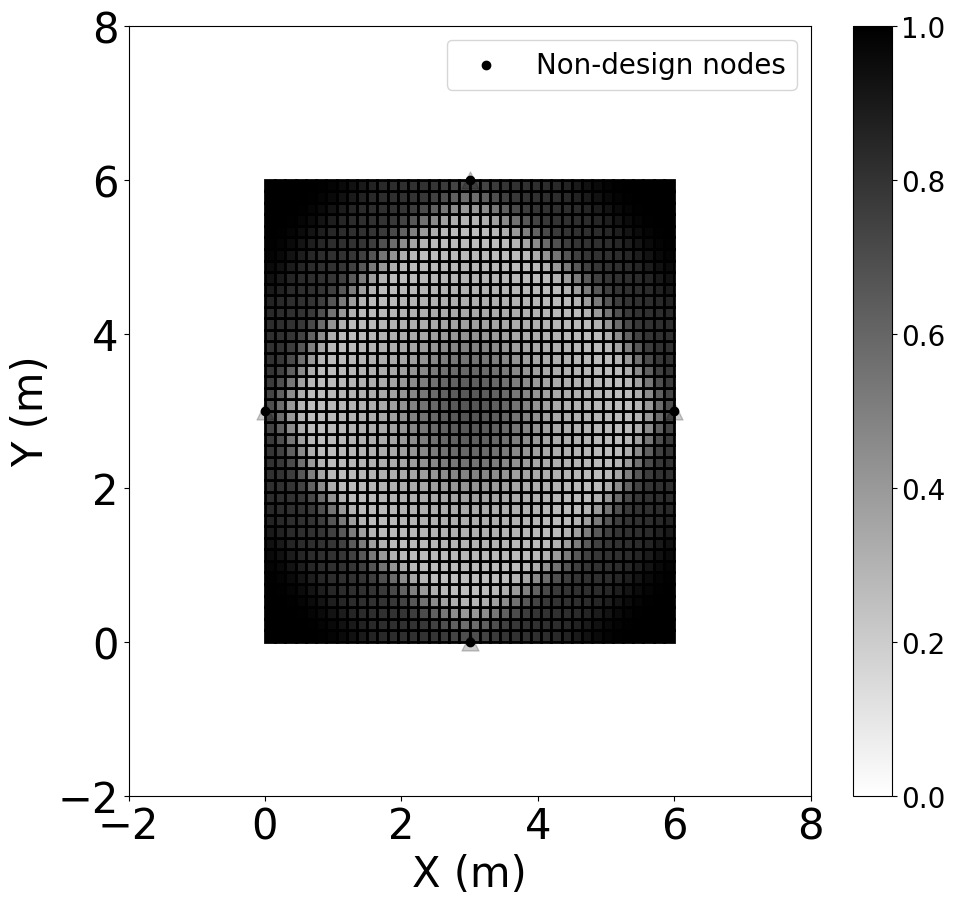

 88%|████████▊ | 180/205 [09:35<01:21,  3.27s/it]

Iter180, alpha=9.1, p=8.0


 88%|████████▊ | 181/205 [09:37<01:14,  3.10s/it]

Train epoch 182  ,loss:0.6029170056650273
Iter181, alpha=9.15, p=8.0


 89%|████████▉ | 182/205 [09:40<01:08,  2.98s/it]

Train epoch 183  ,loss:0.6029548137849623
Iter182, alpha=9.2, p=8.0


 89%|████████▉ | 183/205 [09:43<01:03,  2.89s/it]

Train epoch 184  ,loss:0.6030271728634944
Iter183, alpha=9.25, p=8.0


 90%|████████▉ | 184/205 [09:45<00:59,  2.84s/it]

Train epoch 185  ,loss:0.6031282981353479
Iter184, alpha=9.3, p=8.0
Train epoch 186  ,loss:0.6032392522958265
903.0603946269102


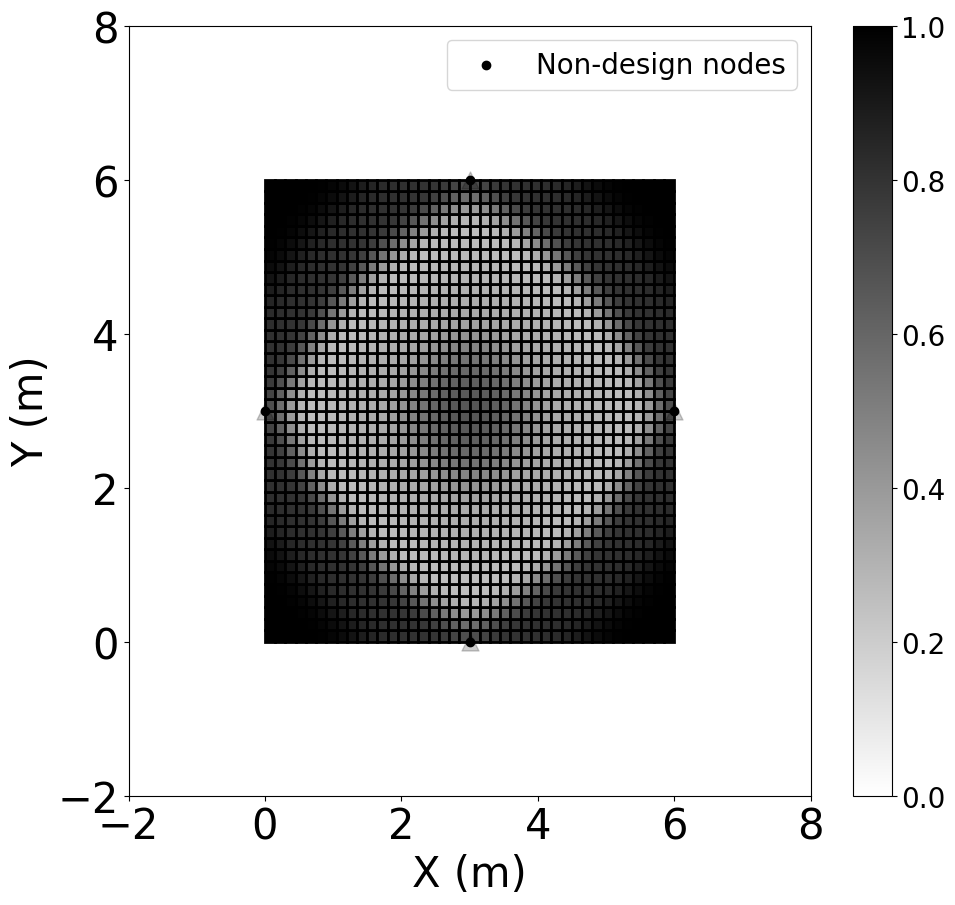

 90%|█████████ | 185/205 [09:49<01:03,  3.19s/it]

Iter185, alpha=9.35, p=8.0


 91%|█████████ | 186/205 [09:52<00:57,  3.04s/it]

Train epoch 187  ,loss:0.6033649511490912
Iter186, alpha=9.4, p=8.0


 91%|█████████ | 187/205 [09:55<00:52,  2.94s/it]

Train epoch 188  ,loss:0.6034910822426277
Iter187, alpha=9.45, p=8.0


 92%|█████████▏| 188/205 [09:57<00:48,  2.87s/it]

Train epoch 189  ,loss:0.6035839366224537
Iter188, alpha=9.5, p=8.0


 92%|█████████▏| 189/205 [10:00<00:45,  2.82s/it]

Train epoch 190  ,loss:0.60369580876521
Iter189, alpha=9.55, p=8.0
Train epoch 191  ,loss:0.6038258010953856
901.1543431327871


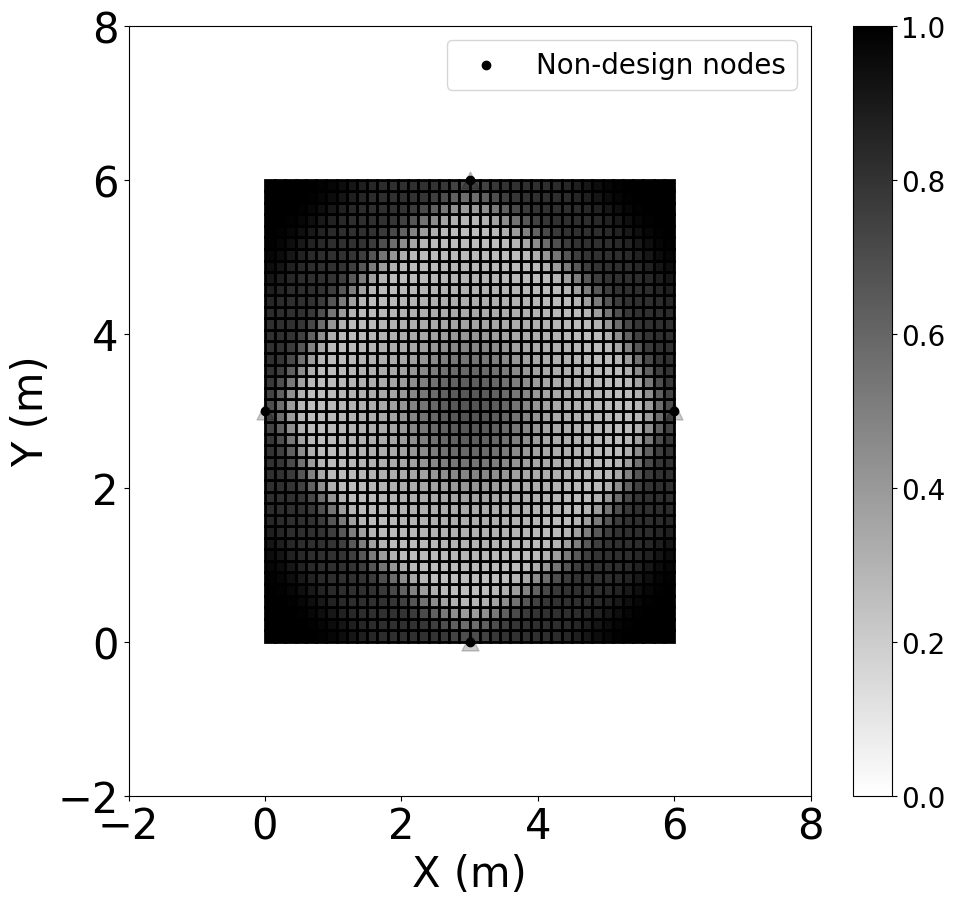

 93%|█████████▎| 190/205 [10:04<00:48,  3.26s/it]

Iter190, alpha=9.6, p=8.0


 93%|█████████▎| 191/205 [10:07<00:43,  3.11s/it]

Train epoch 192  ,loss:0.6039626993736366
Iter191, alpha=9.65, p=8.0


 94%|█████████▎| 192/205 [10:10<00:38,  2.98s/it]

Train epoch 193  ,loss:0.6041334866758462
Iter192, alpha=9.700000000000001, p=8.0


 94%|█████████▍| 193/205 [10:13<00:34,  2.90s/it]

Train epoch 194  ,loss:0.6042967007242255
Iter193, alpha=9.75, p=8.0


 95%|█████████▍| 194/205 [10:15<00:31,  2.84s/it]

Train epoch 195  ,loss:0.6044298618102357
Iter194, alpha=9.8, p=8.0
Train epoch 196  ,loss:0.6045737910712294
898.0608240646552


 95%|█████████▌| 195/205 [10:19<00:32,  3.21s/it]

Iter195, alpha=9.85, p=8.0


 96%|█████████▌| 196/205 [10:22<00:27,  3.06s/it]

Train epoch 197  ,loss:0.6047598529258909
Iter196, alpha=9.9, p=8.0


 96%|█████████▌| 197/205 [10:25<00:23,  2.96s/it]

Train epoch 198  ,loss:0.6050123737348302
Iter197, alpha=9.950000000000001, p=8.0


 97%|█████████▋| 198/205 [10:27<00:20,  2.88s/it]

Train epoch 199  ,loss:0.6054549470109846
Iter198, alpha=10.0, p=8.0


 97%|█████████▋| 199/205 [10:30<00:16,  2.82s/it]

Train epoch 200  ,loss:0.6067605362199832
Iter199, alpha=10.05, p=8.0
Train epoch 201  ,loss:0.6108926685469909
921.3609460811099


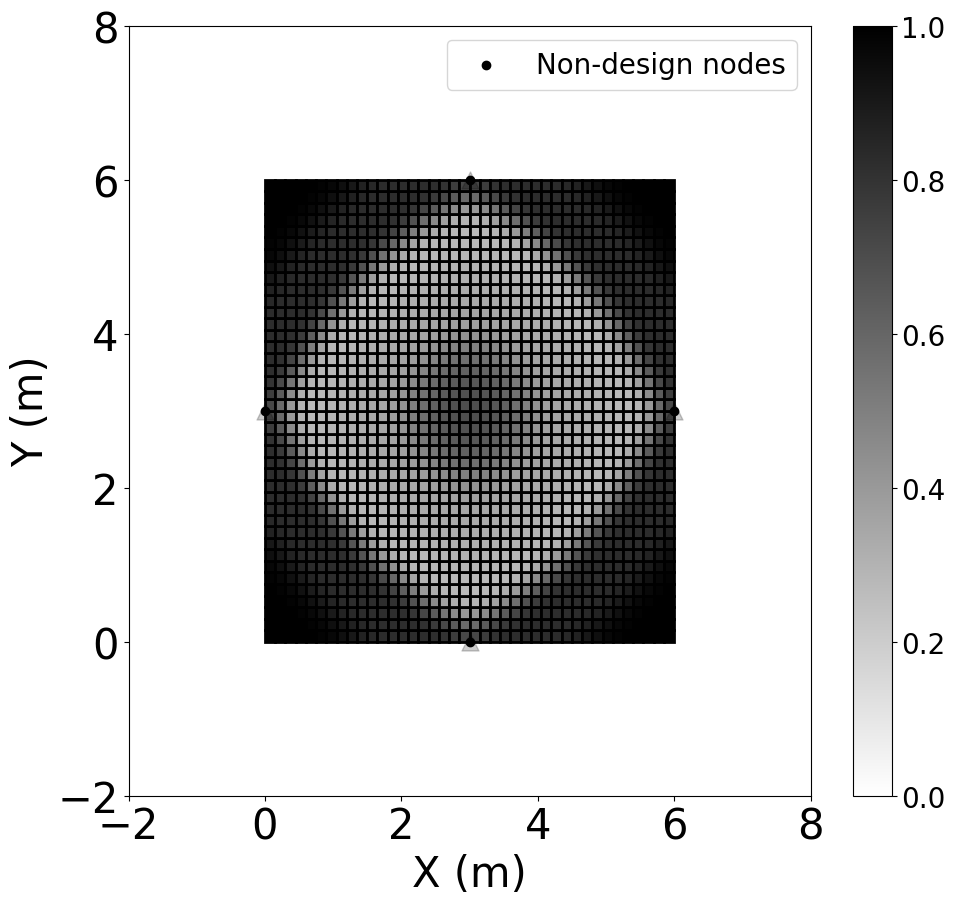

 98%|█████████▊| 200/205 [10:34<00:16,  3.27s/it]

Iter200, alpha=10.1, p=8.0


 98%|█████████▊| 201/205 [10:37<00:12,  3.08s/it]

Train epoch 202  ,loss:0.6267002825175867
Iter201, alpha=10.15, p=8.0


 99%|█████████▊| 202/205 [10:40<00:08,  2.95s/it]

Train epoch 203  ,loss:0.6387857964042231
Iter202, alpha=10.200000000000001, p=8.0


 99%|█████████▉| 203/205 [10:42<00:05,  2.86s/it]

Train epoch 204  ,loss:0.6576933697289099
Iter203, alpha=10.25, p=8.0


100%|█████████▉| 204/205 [10:45<00:02,  2.80s/it]

Train epoch 205  ,loss:0.6071969802619288
Iter204, alpha=10.3, p=8.0
Train epoch 206  ,loss:0.6462763792300981
942.1568873399605


100%|██████████| 205/205 [10:49<00:00,  3.17s/it]


In [39]:
trained_model_state = train_model(model_state, num_epochs=205)

In [40]:
##Apply_fn: ML input to output
outs = trained_model_state.apply_fn(trained_model_state.params, inp) #how to move nodes along z, ML-Outpu
node_params = outs[:,0]
node_rho_params = outs[:,1]

#Final-Z
zs[design_nodes] = og_p(node_params)
zs_filtered = zs.copy()
zs_filtered[design_nodes] =(B_ij@zs)[design_nodes]

#Final density
mu_opt = jnp.average(node_rho_params[cnct],axis=1) #Average per-node density for each shell

In [42]:
outs[:,0]

Array([0.15064163, 0.30012599, 0.54851817, ..., 0.54851817, 0.30012599,
       0.15064163], dtype=float64)

In [130]:
design_nodes[20]

20

In [123]:
zs[non_design_nodes]

array([0.53679601, 2.9963183 , 1.62004906, 1.69808352])

# Visualization

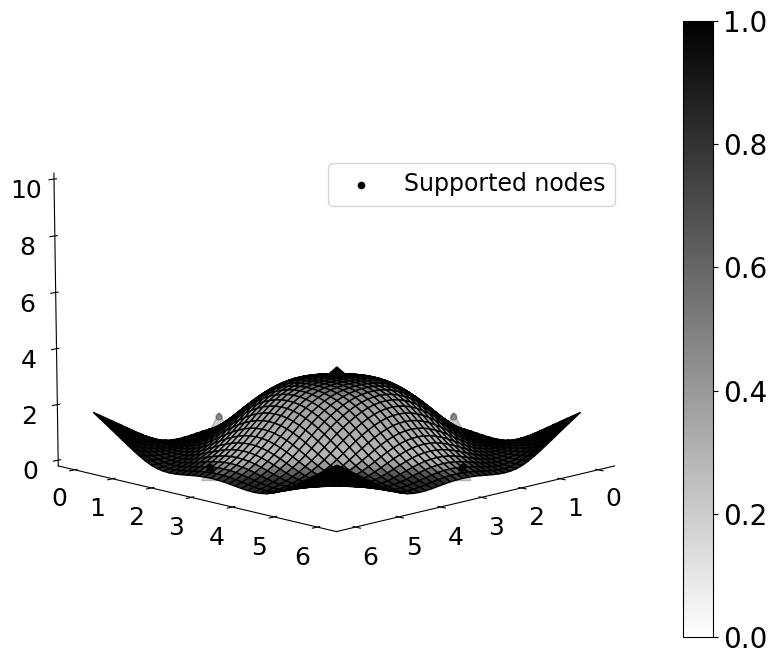

In [44]:
%matplotlib inline




fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(projection='3d')
ax.set_zlim(0,10)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=18)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
  #ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],[z_ele[i,0],z_ele[i,1]],color='black')


import matplotlib as mpl
cmap = mpl.colormaps['binary']
mu_opt_filtered = B_ij_shell@mu_opt
for i in range(n_ele):
    all_corners = []
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    all_corners.append([[xs[inode],ys[inode],zs_filtered[inode]],
                        [xs[jnode],ys[jnode],zs_filtered[jnode]],
                        [xs[mnode],ys[mnode],zs_filtered[mnode]],
                        [xs[nnode],ys[nnode],zs_filtered[nnode]],
                       ])
    #all_corners.append([[xs[inode],ys[inode],zs[inode]],
    #                    [xs[jnode],ys[jnode],zs[jnode]],
    #                    [xs[mnode],ys[mnode],zs[mnode]],
    #                    [xs[nnode],ys[nnode],zs[nnode]],
    #                   ])
    
    tdco = Poly3DCollection(all_corners)
    alpha = float(mu_opt_filtered[i])
    tdco.set_facecolor(cmap(alpha))
    tdco.set_edgecolor('black')
    ax.add_collection3d(tdco)
    


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]+0.35,color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],zs_filtered[non_design_nodes]+0.2,s=150,marker='^',alpha=0.2,color='black')
ax.view_init(10,45)
plt.legend(fontsize=17, loc=(0.5,0.7))
ax.grid(False)
ax.xaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.yaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
ax.zaxis.set_pane_color((1.0, 1.0, 1.0, 1.0))
plt.show()

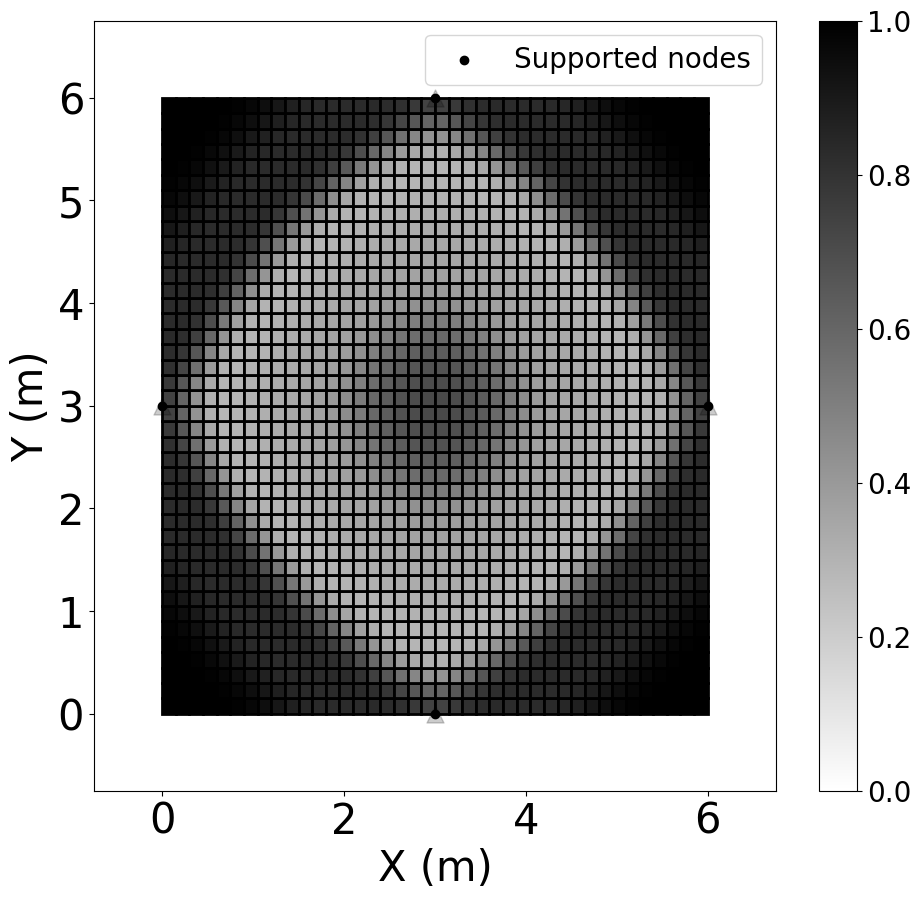

In [45]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-0.75,6.75)
ax.set_xlim(-0.75,6.75)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt_filtered[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Supported nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

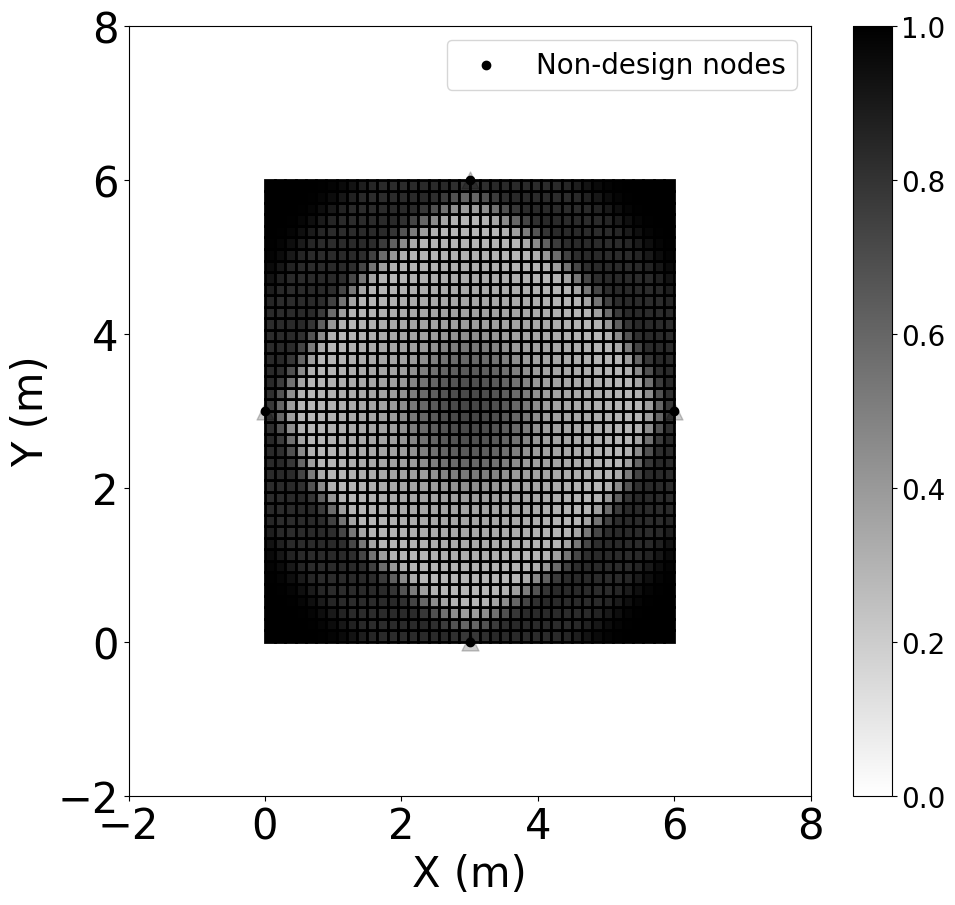

In [46]:

fig,ax = plt.subplots(figsize=(11,10))
ax.set_ylim(-2,8)
ax.set_xlim(-2,8)
plt.xlabel('X (m)',fontsize=30)
plt.ylabel('Y (m)',fontsize=30)
#ax = fig.add_subplot#(projection='3d')
#ax.set_zlim(0,20)
#ax.set_xlabel('X (m)',fontsize=15)
#ax.set_ylabel('Y (m)',fontsize=15)
#ax.set_zlabel('Z (m)',fontsize=15)
all_corners= []
import matplotlib as mpl
cmap = mpl.colormaps['binary']
for i in range(n_ele):
    inode = cnct[i,0]
    jnode = cnct[i,1]
    mnode = cnct[i,2]
    nnode = cnct[i,3]
    this_poly = Polygon([(xs[inode],ys[inode]), (xs[jnode],ys[jnode]), (xs[mnode],ys[mnode]),(xs[nnode],ys[nnode]),])
    alpha = float(mu_opt[i])
    #cthis_poly.set_alpha(alpha)
    this_poly.set_facecolor(cmap(alpha))
    this_poly.set_edgecolor('black')
    this_poly.set_lw(2)
    ax.add_patch(this_poly)

ax.tick_params(axis='both', which='major', labelsize=30)
ax.tick_params(axis='both', which='minor', labelsize=30)
#Plot a basic wireframe.
#for i in range(n_ele_bar):
##  ax.plot([x_ele[i,0],x_ele[i,1]],[y_ele[i,0],y_ele[i,1]],color='darkcyan')

ax.scatter(xs[non_design_nodes],ys[non_design_nodes],color='black',label='Non-design nodes')
ax.scatter(xs[non_design_nodes],ys[non_design_nodes],s=150,marker='^',alpha=0.2,color='black')


cb = plt.colorbar(mpl.cm.ScalarMappable( cmap=cmap), ax=ax)
cb.ax.tick_params(labelsize=20)
plt.legend(fontsize=20)# loc=(0.5,0.7))
ax.grid(False)
plt.show()

In [106]:
jnp.sum(mu_opt)

Array(800.34499146, dtype=float64)

In [107]:
jnp.sum(mu_opt)

Array(800.34499146, dtype=float64)

In [108]:
0.5*sso_model.eleparameters_values.shape[0]

800.0

In [ ]:
mu_opt_filtered

In [82]:
jnp.min(mu_opt)

Array(0.49547004, dtype=float64)

In [83]:
jnp.max(mu_opt)

Array(0.54537502, dtype=float64)

In [86]:
jnp.max(model_state.apply_fn(params, inp)[:,1])

Array(0.52117628, dtype=float64)

In [87]:
jnp.min(model_state.apply_fn(params, inp)[:,1])

Array(0.5, dtype=float64)

In [89]:
np.max(zs)

1.827663999013847

In [90]:
np.min(zs)

1.4122399536942798